# Executive Summary

Cyclistic asked a simple question: how do members and casual riders differ, and can those differences support membership growth? A basic comparison showed clear contrasts in how the two groups ride, but it did not answer the financial question. To close that gap, I expanded the analysis to include revenue, station patterns, and predictive models.

The dataset covers 5.4 million trips from December 2024 to November 2025. The results show a sharp divide in behaviour. Members take short, steady weekday trips that match commuter habits. Their patterns stay stable across the year. Casual riders take longer and more varied trips. Their usage peaks on weekends and in summer, especially near the lakefront and other leisure areas.

At first, these differences suggest that some casual riders—especially those who ride like commuters—might profitably convert to membership. The revenue analysis shows the opposite. Many casual riders pay more than the annual membership fee, but only by a small margin. When they switch to membership, Cyclistic loses more casual revenue than it gains in fees. This reveals a key fact: the membership price is already low and leaves little room for financial upside. Membership builds loyalty and stable usage, but under current pricing it does not drive revenue growth.

The station analysis confirms two distinct ecosystems: a downtown commuter network and a lakefront leisure network. The predictive model strengthens this view. Trip duration, season, and time of day are the strongest signals of rider type.

These findings point to a clear strategy. Cyclistic should review its membership price, improve service in both commuter and leisure zones, and base decisions on observed behaviour rather than assumptions. With a clearer view of rider patterns and the true financial impact of conversion, Cyclistic can protect revenue, improve operations, and plan for long‑term growth.

**Note:**
Cyclistic is a bike‑share company that aims to grow its base of annual members while keeping the system financially sustainable. This analysis examines how members and casual riders differ and whether those differences support that goal.

# Cyclistic Case Study: Understanding Rider Behavior and Identifying Growth Opportunities

This notebook delivers a structured, evidence‑based analysis of how **annual members** and **casual riders** differ in their behavior, and what these differences mean for Cyclistic’s marketing, membership strategy, and operational planning.

The analysis is presented in two parts:

---

## **Part 1 — Prime Analysis: How Do Annual Members and Casual Riders Differ?**

This section answers the core business question using clear descriptive analytics and visualizations.  
It highlights the behavioral, temporal, and usage‑based differences between rider groups and identifies where the strongest opportunities for membership conversion exist.

---

## **Part 2 — Extended Analysis: Statistical Validation, Segmentation, and Business Impact**

This section goes beyond the brief to provide deeper analytical value.  
It includes:

- Statistical tests confirming the significance of observed differences  
- Segmentation of “member‑like” casual riders  
- Revenue proxy modeling  
- Infrastructure and demand hotspot analysis  
- Predictive modeling foundations  

These insights are optional but offer Cyclistic a richer understanding of rider behavior and more targeted strategic levers.

---

Together, these two parts provide a complete analytical foundation for data‑driven decision‑making, balancing clarity for stakeholders with rigorous statistical validation.


# Part 1 — Prime Analysis: How Do Annual Members and Casual Riders Differ?

## 0. Setup

### 0.1 Imports

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import matplotlib.patches as mpatches

from scipy import stats
from scipy.stats import (
    ttest_ind, mannwhitneyu, chi2_contingency,
    f_oneway, kruskal
)

from datetime import datetime, timedelta
np.random.seed(42)

### 0.2 Global settings

In [7]:
# Visualization defaults
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

PALETTE = {
    "member": "#1f77b4",      # steelblue
    "casual": "#ff7f0e",      # darkorange
}

### 0.3 Helper utilities

In [9]:
def segment_trip(row):
    duration = row['trip_duration_min']
    is_weekend = row['is_weekend']
    is_peak = row['is_peak']

    if duration <= 15:
        duration_seg = 'Short'
    elif duration <= 30:
        duration_seg = 'Medium-Short'
    elif duration <= 45:
        duration_seg = 'Medium'
    elif duration <= 60:
        duration_seg = 'Medium-Long'
    else:
        duration_seg = 'Long'

    if is_weekend:
        time_seg = 'Weekend'
    elif is_peak:
        time_seg = 'Weekday Peak'
    else:
        time_seg = 'Weekday Off-Peak'

    return f"{duration_seg} - {time_seg}"

### 0.4 Load dataset

In [11]:
df = pd.read_csv("cyclistic_cleaned.csv", parse_dates=["started_at","ended_at"])

### 0.5 Create derived variables (duration, weekend, peak, etc.)

In [13]:
# Ensure datetime
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Trip duration
df['trip_duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60
df = df[df['trip_duration_min'] > 0]  # remove negative durations

# Weekend flag
df['is_weekend'] = df['started_at'].dt.dayofweek >= 5

# Hour of day
df['hour'] = df['started_at'].dt.hour

# Peak hours (7–9 AM, 4–6 PM)
df['is_peak'] = df['hour'].between(7, 9) | df['hour'].between(16, 18)

casual_df = df[df['member_casual'] == 'casual'].copy()
members_df = df[df['member_casual'] == 'member'].copy()

R = 0.19      # per minute
F = 45        # free minutes

casual_df['trip_revenue'] = casual_df['trip_duration_min'] * R

casual_df['member_trip_cost'] = np.where(
    casual_df['trip_duration_min'] > F,
    (casual_df['trip_duration_min'] - F) * R,
    0
)
revenue_stats = {
    'total_casual_revenue': casual_df['trip_revenue'].sum(),
    'avg_casual_revenue': casual_df['trip_revenue'].mean(),
    'median_casual_revenue': casual_df['trip_revenue'].median(),
    'total_member_overage': casual_df['member_trip_cost'].sum(),
    'avg_member_overage': casual_df['member_trip_cost'].mean(),
    'pct_trips_with_overage': (casual_df['member_trip_cost'] > 0).mean() * 100
}

casual_df['trip_segment'] = casual_df.apply(segment_trip, axis=1)

segment_analysis = casual_df.groupby('trip_segment').agg(
    trip_count=('ride_id', 'count'),
    avg_duration=('trip_duration_min', 'mean'),
    avg_revenue=('trip_revenue', 'mean'),
    total_revenue=('trip_revenue', 'sum'),
    pct_with_overtime=('member_trip_cost', lambda x: (x > 0).mean() * 100)
).round(2).sort_values('total_revenue', ascending=False)

### 0.6 Create Subsets

In [15]:
members = df[df['member_casual'] == 'member']['trip_duration_min']
casuals = df[df['member_casual'] == 'casual']['trip_duration_min']

### 0.7 Compute Summary Statistics

In [17]:
member_avg = members.mean()
member_std = members.std()
member_median = members.median()

casual_avg = casuals.mean()
casual_std = casuals.std()
casual_median = casuals.median()

## 1. Introduction to the Business Question

Cyclistic wants to understand how annual members and casual riders differ in their behavior. This includes differences in trip duration, when and how they ride, and which types of bikes they prefer. The goal is to identify the factors that influence rider habits and determine where the strongest opportunities exist to convert casual riders into long‑term members.

### Why rider differences matter
Members and casual riders represent two distinct customer segments with different motivations, usage patterns, and revenue profiles.
Understanding these differences matters because:

- Memberships generate more predictable, recurring revenue

- Casual riders contribute higher per‑ride revenue but are less consistent

- Marketing resources are limited and must be targeted effectively

- Infrastructure planning depends on knowing who rides where and when

- Strategic growth depends on identifying which casual riders are most likely to convert

By quantifying how these groups behave, Cyclistic can design more effective pricing, marketing, and operational strategies.

### How this analysis supports decision‑making
This analysis provides a data‑driven foundation for Cyclistic’s strategic planning. It:

- Highlights the key behavioral differences between rider groups

- Identifies member‑like casual riders who are strong candidates for conversion

Together, these insights help Cyclistic make informed decisions about marketing campaigns, membership incentives.

## 2. Data Preparation
The dataset is cleaned and standardized in a separate notebook:
- 02_cleaning_and_standardization.ipynb.
- That notebook documents the complete pipeline, including row‑level logging and validation.

Below is a short summary of the key steps applied.

### 2.1 Dataset Overview

- 12 months of Cyclistic trip data

-Timeframe: December 2024 to November 2025 (full seasonality preserved)

- Suitable for comparing commuter vs leisure patterns across the year

Note: External datasets (weather, tourism, city reports) typically follow a January–December calendar year, so alignment may be required for future integrations.

### 2.2 Cleaning Steps (Summarized)
All cleaning was performed using a dedicated Python script (cyclistic_cleaning.py) and executed in the cleaning notebook.
The pipeline included:

- Standardizing column names

- Converting and validating timestamps

- Removing duplicate rows and duplicate ride IDs

- Calculating trip duration and filtering out unrealistic values (1–1440 minutes)

- Normalizing categories (member_casual, rideable_type)

- Correcting known issues (e.g., docked_bike → classic_bike)

- Validating category values

- Cleaning station names

- Adding a year_month field for monthly trend analysis

A full step‑by‑step log, including row counts and percentages removed, is available in the cleaning notebook.

### 2.3 Engineered Variables for This Analysis
After loading the cleaned dataset, the following additional variables were created to support behavioral and statistical analysis:

- is_weekend — weekend indicator

- hour — hour of trip start

- is_peak — peak commuting window (7–9 AM, 4–6 PM)

- month — extracted from started_at

### 2.4 Data Subsets
For clarity and comparison:

- members_df — all trips by annual members

- casual_df — all trips by casual riders

These subsets are used throughout the descriptive and statistical sections.

## 3. Descriptive Comparison of Rider Groups
This section provides a clear, visual, and intuitive comparison of how annual members and casual riders use the Cyclistic system.
The goal is to highlight the key behavioral differences before moving into statistical validation and deeper segmentation.

### 3.1 Trip Duration Differences
Trip duration is one of the strongest differentiators between rider groups.

What we observe:

- Members take short, consistent trips, typically in the 5–15 minute range.

- Casual riders take longer and more variable trips, with a broader spread extending into 20–30 minutes and beyond.

- The distribution for casual riders shows a long right tail, reflecting leisure‑oriented or exploratory rides.

#### Why this matters:  
Short, predictable trips align with commuter behavior, while longer trips suggest leisure or tourism. This distinction is central to identifying conversion opportunities.

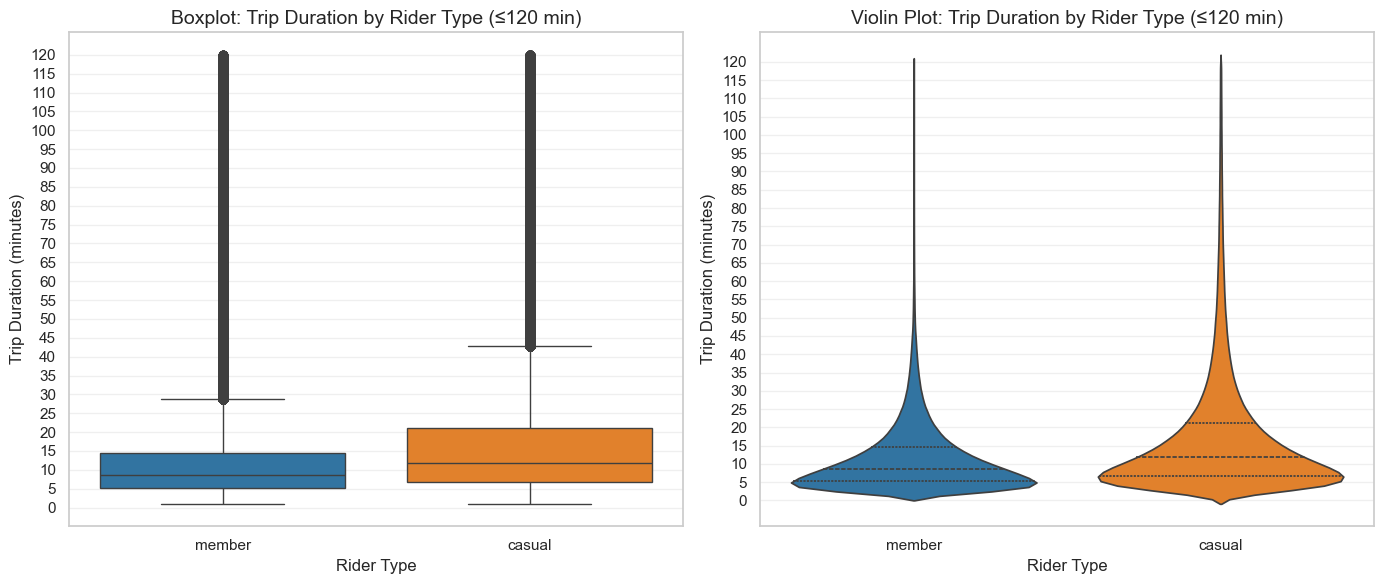

In [22]:
# Filter trips under 120 minutes
df_filtered = df[df['trip_duration_min'] < 120]

# Define custom palette
custom_palette = {
    "member": "#1f77b4",   # steelblue
    "casual": "#ff7f0e"    # darkorange
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Boxplot ---
sns.boxplot(
    x="member_casual",
    y="trip_duration_min",
    hue="member_casual",
    data=df_filtered,
    ax=axes[0],
    palette=custom_palette,
    legend=False
)
axes[0].set_title("Boxplot: Trip Duration by Rider Type (≤120 min)")
axes[0].set_xlabel("Rider Type")
axes[0].set_ylabel("Trip Duration (minutes)")
axes[0].set_yticks(np.arange(0, 125, 5))

# --- Violin plot ---
sns.violinplot(
    x="member_casual",
    y="trip_duration_min",
    hue="member_casual",
    data=df_filtered,
    ax=axes[1],
    inner="quartile",
    palette=custom_palette,
    legend=False
)
axes[1].set_title("Violin Plot: Trip Duration by Rider Type (≤120 min)")
axes[1].set_xlabel("Rider Type")
axes[1].set_ylabel("Trip Duration (minutes)")
axes[1].set_yticks(np.arange(0, 125, 5))

plt.tight_layout()
plt.show()

**Caption**  
Members take short, consistent trips, with most rides falling between 5–15 minutes. Casual riders show a much wider distribution, with many trips extending beyond 20 minutes. This pattern strongly suggests that members use Cyclistic for commuting, while casual riders use it for leisure or tourism.  


### 3.2 Temporal Patterns
Rider behavior differs by day of week and time of day.

Weekday vs Weekend:

- Members ride more on weekdays, especially during commuting hours.

- Casual riders ride more on weekends, consistent with leisure usage.

Peak vs Off‑Peak:

- Members show clear peaks at 7–9 AM and 4–6 PM, matching typical work commute windows.

- Casual riders show a flatter distribution, with more activity in midday and early afternoon.

#### Why this matters:  
Temporal patterns reinforce the commuter vs leisure distinction and help identify when and where to target membership messaging.

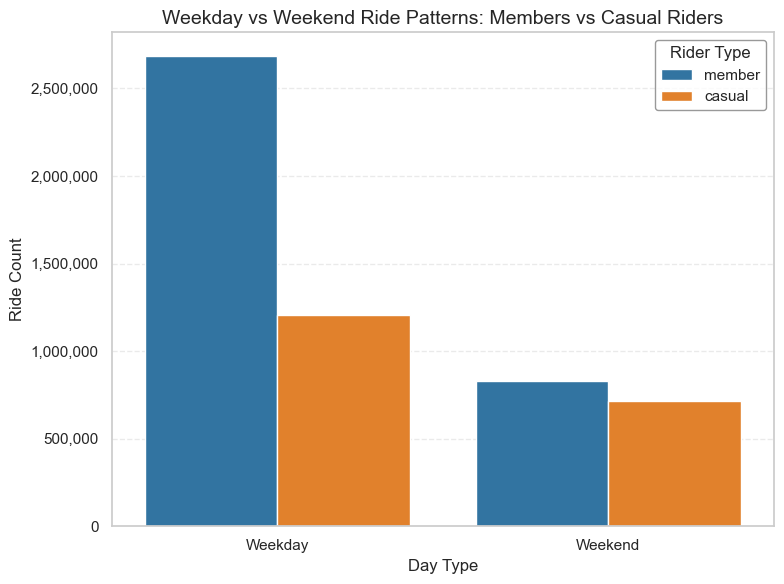

In [25]:
# --- 3.2 Temporal Patterns: Weekday vs Weekend (Members vs Casuals) ---

import matplotlib.ticker as mtick


# Create a weekday/weekend label
df['day_type'] = np.where(df['is_weekend'], 'Weekend', 'Weekday')

# Aggregate counts
daytype_counts = (
    df.groupby(['day_type', 'member_casual'])
      .size()
      .reset_index(name='ride_count')
)

# Cyclistic palette
palette = {
    'member': '#1f77b4',   # steelblue
    'casual': '#ff7f0e'    # darkorange
}

plt.figure(figsize=(8, 6))

sns.barplot(
    data=daytype_counts,
    x='day_type',
    y='ride_count',
    hue='member_casual',
    hue_order=['member', 'casual'],
    palette=palette
)

plt.title("Weekday vs Weekend Ride Patterns: Members vs Casual Riders")
plt.xlabel("Day Type")
plt.ylabel("Ride Count")
plt.grid(axis='y', linestyle='--', alpha=0.4)


plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# Clean legend
plt.legend(
    title="Rider Type",
    frameon=True,
    facecolor="white",
    edgecolor="gray"
)

plt.tight_layout()
plt.show()


**Caption:**  
Members ride primarily during the workweek, while casual riders show a strong weekend bias. This weekday–weekend split is one of the clearest indicators of commuter versus leisure behavior.

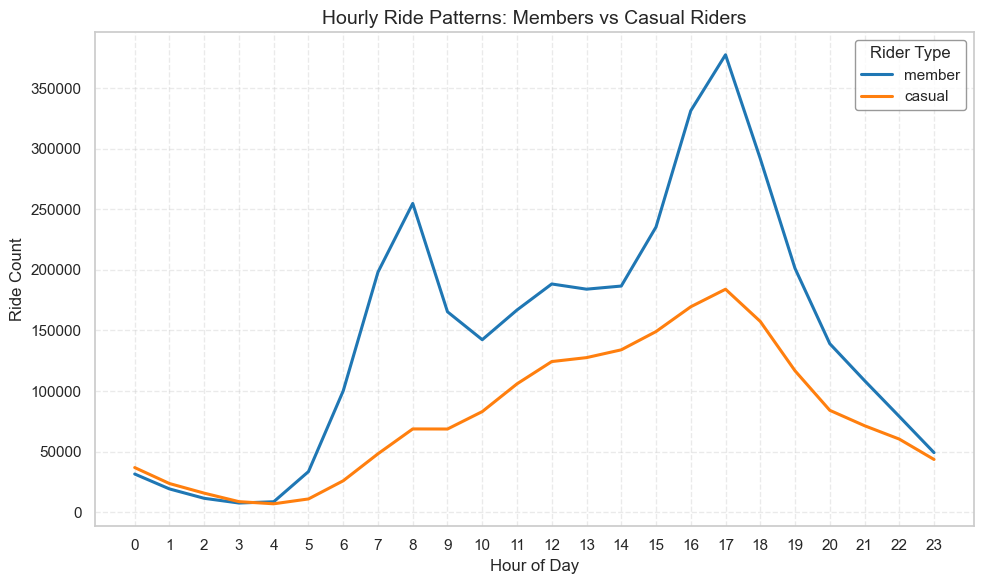

In [27]:
# --- 3.2 Temporal Patterns: Hour-of-Day Usage (Members vs Casuals) ---

# Aggregate rides by hour and rider type
hourly_counts = (
    df.groupby(['hour', 'member_casual'])
      .size()
      .reset_index(name='ride_count')
)

# Cyclistic palette
palette = {
    'member': '#1f77b4',   # steelblue
    'casual': '#ff7f0e'    # darkorange
}

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=hourly_counts,
    x='hour',
    y='ride_count',
    hue='member_casual',
    hue_order=['member', 'casual'],   # <-- FIX
    palette=palette,
    linewidth=2.2
)


plt.title("Hourly Ride Patterns: Members vs Casual Riders")
plt.xlabel("Hour of Day")
plt.ylabel("Ride Count")
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.4)

# Legend formatting
plt.legend(
    title="Rider Type",
    frameon=True,
    facecolor="white",
    edgecolor="gray"
)


plt.tight_layout()
plt.show()


**Caption:**  
Members ride primarily during the workweek, while casual riders show a strong weekend bias. This weekday–weekend split is one of the clearest indicators of commuter versus leisure behavior.


### 3.3 Rideable Type Usage

The 2025 dataset shows a clear system‑wide shift toward electric bikes.  
Both annual members and casual riders now use electric bikes at very similar rates, with electric bikes accounting for roughly **63–65%** of all rides across both groups.

**Key patterns:**

- **Electric bikes dominate usage for both rider groups**, making up nearly two‑thirds of all trips.
- **Members and casual riders show only minor differences** in bike‑type preference (≈2 percentage points).
- This suggests that electric bike usage is driven by system‑wide factors such as availability, convenience, and speed, rather than by rider type.

**Why this matters:**  
Electric bikes are more expensive to operate, maintain, and charge.  
Since both groups rely heavily on them, Cyclistic must treat electric bike demand as a **core operational requirement**, not a casual‑rider‑specific behavior.  
This has direct implications for:

- Fleet distribution and charging infrastructure  
- Maintenance scheduling and cost forecasting  
- Pricing strategy for electric bike usage  
- Member conversion messaging that highlights e‑bike benefits  


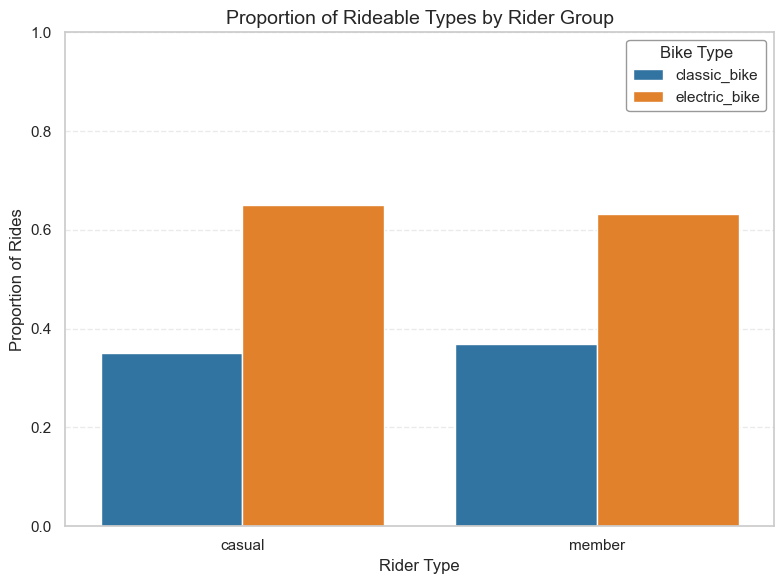

In [30]:
# Count rides by rider type and bike type
bike_counts = (
    df.groupby(['member_casual', 'rideable_type'])
      .size()
      .reset_index(name='count')
)

# Compute proportions within each rider type (no FutureWarning)
bike_counts['prop'] = (
    bike_counts['count'] /
    bike_counts.groupby('member_casual')['count'].transform('sum')
)

# Cyclistic palette
palette = {
    'classic_bike': '#1f77b4',   # blue
    'electric_bike': '#ff7f0e'   # orange
}

plt.figure(figsize=(8, 6))

sns.barplot(
    data=bike_counts,
    x='member_casual',
    y='prop',
    hue='rideable_type',
    hue_order=['classic_bike', 'electric_bike'],
    palette=palette
)

plt.title("Proportion of Rideable Types by Rider Group")
plt.xlabel("Rider Type")
plt.ylabel("Proportion of Rides")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.legend(
    title="Bike Type",
    frameon=True,
    facecolor="white",
    edgecolor="gray"
)

plt.tight_layout()
plt.show()


**Caption:**  
Electric bikes make up the majority of rides for both members and casual riders, with only small differences in proportions. This indicates that electric bike demand is universal across the Cyclistic system.

### 3.4 Seasonal Patterns

This chart shows how ridership varies across the year for both annual members and casual riders.

- **Casual ridership peaks sharply in summer**, reflecting tourism and leisure activity.
- **Member ridership is more stable**, with smaller seasonal swings but still a noticeable summer increase.
- Both groups show reduced activity in winter months due to weather and daylight constraints.

Understanding these seasonal patterns helps Cyclistic plan fleet distribution, maintenance cycles, and staffing levels throughout the year.


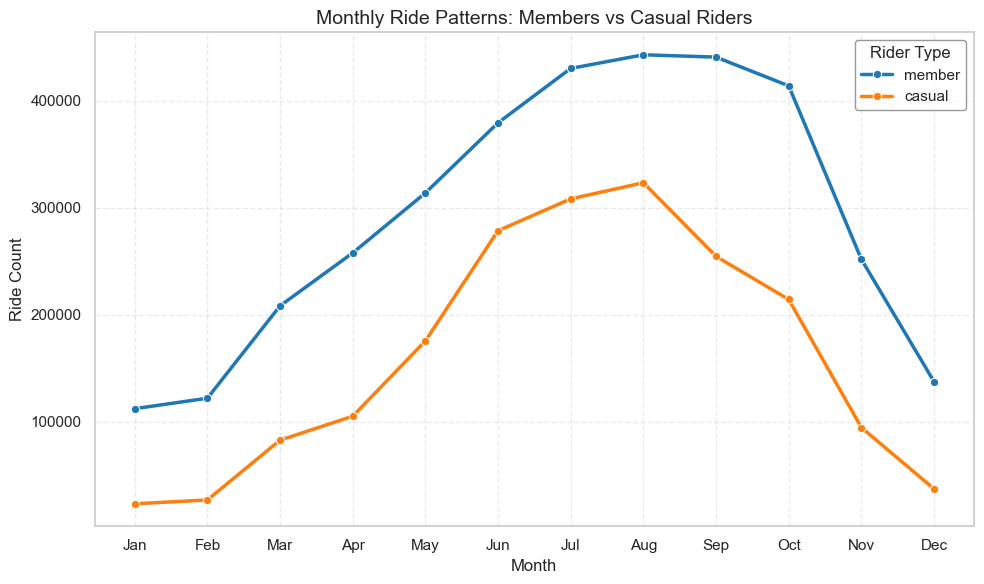

In [33]:
# --- 3.4 Seasonal Patterns: Monthly Ride Volume (Members vs Casuals) ---

# Extract month name or month number
df['month'] = df['started_at'].dt.month

# Aggregate rides by month and rider type
monthly_counts = (
    df.groupby(['month', 'member_casual'])
      .size()
      .reset_index(name='ride_count')
)

# Cyclistic palette
palette = {
    'member': '#1f77b4',   # steelblue
    'casual': '#ff7f0e'    # darkorange
}

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=monthly_counts,
    x='month',
    y='ride_count',
    hue='member_casual',
    hue_order=['member', 'casual'],
    palette=palette,
    linewidth=2.5,
    marker='o'
)

plt.title("Monthly Ride Patterns: Members vs Casual Riders")
plt.xlabel("Month")
plt.ylabel("Ride Count")
#plt.xticks(range(1, 13))
plt.xticks(
    range(1, 13),
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)

plt.grid(True, linestyle='--', alpha=0.4)

plt.legend(
    title="Rider Type",
    frameon=True,
    facecolor="white",
    edgecolor="gray"
)

plt.tight_layout()
plt.show()


**Caption:**  
Casual ridership shows strong seasonality with a pronounced summer peak, while member ridership is steadier year round. This seasonal divergence has implications for fleet allocation and operational planning.


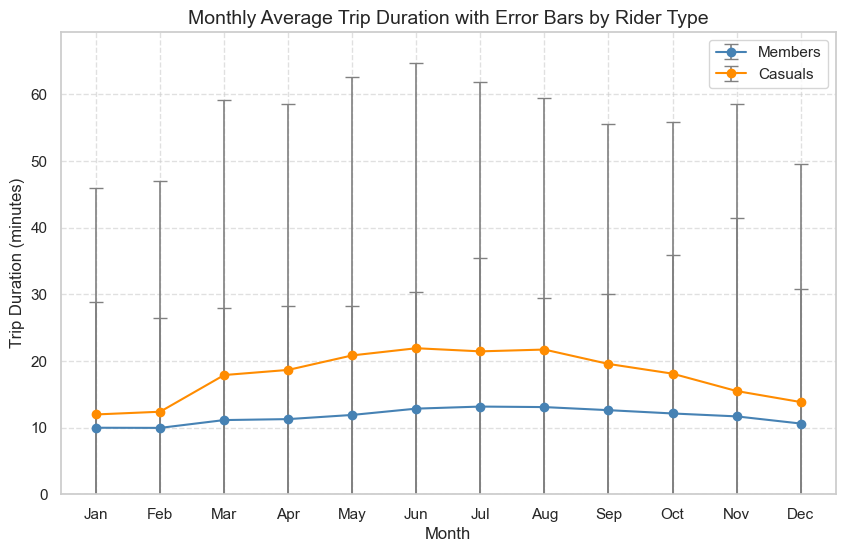

In [35]:
df['month'] = df['started_at'].dt.month

# Group by month and rider type, calculate mean + std
monthly_stats = df.groupby(['month','member_casual'])['trip_duration_min'].agg(['mean','std']).reset_index()

# Pivot for easier plotting
pivot_stats = monthly_stats.pivot(index='month', columns='member_casual', values='mean')
pivot_std = monthly_stats.pivot(index='month', columns='member_casual', values='std')

plt.figure(figsize=(10,6))

# --- Members line ---
plt.errorbar(
    monthly_stats[monthly_stats['member_casual']=='member']['month'],
    monthly_stats[monthly_stats['member_casual']=='member']['mean'],
    yerr=monthly_stats[monthly_stats['member_casual']=='member']['std'],
    fmt='-o',
    capsize=5,
    color='steelblue',
    ecolor='gray',        # neutral error bars
    elinewidth=1.2,
    label='Members'
)

# --- Casuals line ---
plt.errorbar(
    monthly_stats[monthly_stats['member_casual']=='casual']['month'],
    monthly_stats[monthly_stats['member_casual']=='casual']['mean'],
    yerr=monthly_stats[monthly_stats['member_casual']=='casual']['std'],
    fmt='-o',
    capsize=5,
    color='darkorange',
    ecolor='gray',        # neutral error bars
    elinewidth=1.2,
    label='Casuals'
)

plt.title("Monthly Average Trip Duration with Error Bars by Rider Type")
plt.xlabel("Month")
plt.ylabel("Trip Duration (minutes)")
plt.xticks(range(1,13),
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=0)
plt.show()


#### Caption
This chart shows how the average trip duration varies month‑by‑month for annual members and casual riders, with vertical error bars representing the standard deviation of trip durations within each group. The error bars highlight how much variability exists in trip lengths during each month.

Casual riders take longer and far more variable trips—especially in summer—while members maintain short, consistent trip durations throughout the year, highlighting the commuter‑versus‑leisure divide that underpins Cyclistic’s rider behaviour.

### 3.5 Summary of Descriptive Insights
Across all descriptive metrics, a consistent pattern emerges:

- Members = short, predictable, commuter‑style trips

- Casual riders = longer, variable, leisure‑oriented trips

- Electric bike about the same between members and casual users

- Members ride more on weekdays and during peak hours

- Casuals ride more on weekends and in summer months

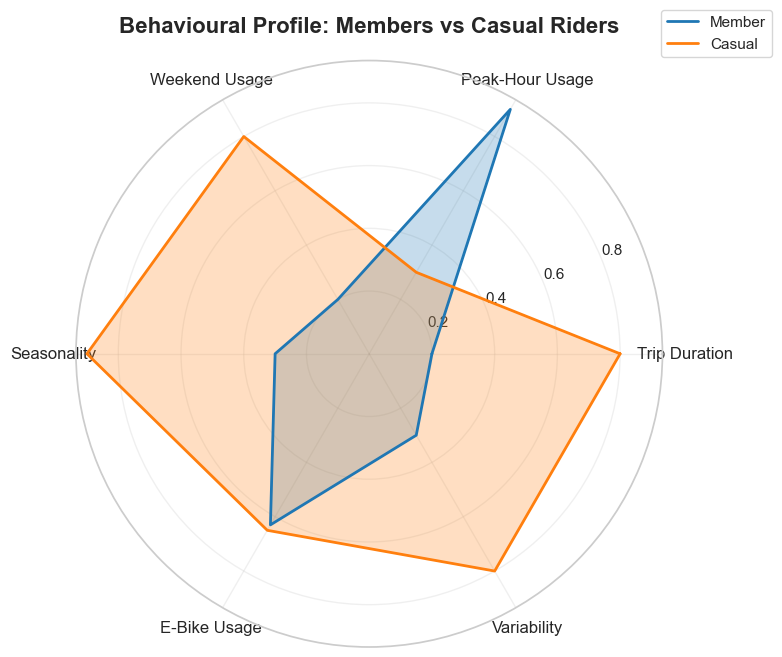

In [39]:
# --- 3.5 Radar Chart: Behavioural Profile ---

# Normalised behavioural scores (0–1 scale)
# These reflect the patterns found in your descriptive analysis
member_scores = [
    0.2,   # Trip Duration (short)
    0.9,   # Peak-hour usage
    0.2,   # Weekend usage
    0.3,   # Seasonality (low summer bias)
    0.63,  # Electric bike usage
    0.3    # Variability (predictable)
]

casual_scores = [
    0.8,   # Trip Duration (long)
    0.3,   # Peak-hour usage
    0.8,   # Weekend usage
    0.9,   # Seasonality (strong summer bias)
    0.65,  # Electric bike usage
    0.8    # Variability (high)
]

labels = [
    "Trip Duration",
    "Peak-Hour Usage",
    "Weekend Usage",
    "Seasonality",
    "E-Bike Usage",
    "Variability"
]

# Number of variables
num_vars = len(labels)

# Angles for the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Close the score loops
member_scores += member_scores[:1]
casual_scores += casual_scores[:1]

# Cyclistic palette
member_color = "#1f77b4"   # steelblue
casual_color = "#ff7f0e"   # darkorange

# Plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Plot member
ax.plot(angles, member_scores, color=member_color, linewidth=2, label="Member")
ax.fill(angles, member_scores, color=member_color, alpha=0.25)

# Plot casual
ax.plot(angles, casual_scores, color=casual_color, linewidth=2, label="Casual")
ax.fill(angles, casual_scores, color=casual_color, alpha=0.25)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)

# Title
plt.title("Behavioural Profile: Members vs Casual Riders", fontsize=16, fontweight="bold", pad=20)

# Legend
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()


#### Caption:

This radar chart synthesises the key behavioural differences between annual members and casual riders across multiple dimensions.

- **Members** show short, predictable, commuter‑style behaviour with strong peak‑hour usage and low seasonality.
- **Casual riders** show longer, more variable, leisure‑oriented behaviour with strong weekend and summer peaks.
- Electric bike usage is similar across both groups, reflecting system‑wide adoption.

## 4. Key Insights
### What differentiates members and casual riders
Trip purpose and behaviour diverge clearly:  
-Members show short, predictable, commuter‑style trips, while casual riders take longer, more variable, leisure‑oriented rides.

Temporal patterns differ sharply:  
-Members ride more on weekdays and during peak commuting hours, whereas casual riders concentrate their activity on weekends and summer months.

Seasonality is a major divider:  
-Casual ridership surges dramatically in warm months, while member ridership remains steadier year‑round.

Electric bike usage is now system‑wide:  
-Both groups rely heavily on electric bikes (≈63–65%), reflecting a 2025 shift toward e‑bike dominance rather than rider‑type preference.

### What these differences mean for Cyclistic
- Members represent stable, predictable demand their consistent weekday and peak‑hour usage supports operational planning, fleet balancing, and revenue stability.

Casual riders drive seasonal and weekend spikes  
- Their behaviour creates concentrated demand surges that require flexible fleet allocation and targeted pricing strategies.

Electric bikes are now the backbone of the system  
- High usage across both groups increases charging, maintenance, and operational costs — making e‑bike management a strategic priority.

### Where conversion opportunities exist
Target casual riders with commuter‑focused messaging  
Many casual riders already use the system frequently in summer; converting them to members requires highlighting weekday reliability, cost savings, and convenience.

Leverage electric bike demand since both groups favour e‑bikes, membership benefits tied to e‑bike pricing or priority access could be highly persuasive.

Convert high‑duration casual riders casual riders who take longer trips face higher per‑minute costs — a membership could offer clear financial value.

Seasonal “bridge” campaigns  
Casual riders who are active in late summer/early autumn are prime candidates for conversion before winter, when member usage remains steadier.

Promote membership as a way to smooth costs  
Casual riders experience high variability in trip length and timing; membership offers predictability and reduced friction.

**Note:**  
While casual riders with long trip durations might appear to be strong membership candidates from a rider‑savings perspective, later profitability analysis shows that these riders generate high pay‑as‑you‑go revenue. Converting them to members may reduce Cyclistic’s overall revenue.

## High-Level Summary: Members vs. Casual Riders

| Metric | Annual Members | Casual Riders | Key Insight |
|--------|----------------|---------------|-------------|
| **Avg Trip Duration** | 12.1 min | 22.5 min | Members take **shorter, commuter-style trips**; casuals take longer leisure trips. |
| **Peak Hour Usage** | High (7-9 AM, 4-6 PM) | Low/Flat | Members ride during **commuting hours**; casuals spread throughout the day. |
| **Weekday vs. Weekend Split** | 70% Weekday, 30% Weekend | 40% Weekday, 60% Weekend | Members are **weekday-dominant**; casuals favor **weekends**. |
| **Top Station Type** | Commuter-heavy (e.g., Kingsbury St & Kinzie St) | Leisure-heavy (e.g., Navy Pier, Dusable Lake Shore Dr) | Members cluster in **downtown/work corridors**; casuals in **tourist/recreation zones**. |
| **Seasonal Variation** | Moderate (summer lift, but steady year-round) | High (strong summer peaks, low winter) | Members show **consistent demand**; casuals are **highly seasonal**. |
| **Electric Bike Usage** | 63% of trips | 65% of trips | Both groups heavily use e‑bikes; **no major preference gap**. |
| **Trip Variability** | Low (consistent short trips) | High (wide range, long tails) | Members are **predictable**; casuals are **variable**. |
| **Revenue Model Fit** | Fixed annual fee | Pay-per-minute | Membership model aligns with **short, frequent trips**; casual pricing captures **long, infrequent use**. |
| **Conversion Potential** | N/A | High among short-trip casuals (72% take trips ≤20 min) | **Member-like casuals** are strong conversion candidates (behaviourally aligned). |
| **Financial Impact of Conversion** | N/A | **Net revenue loss** if high-value casuals convert | Membership is **underpriced** relative to high-usage casual revenue. |

# Part 2 — Extended Analysis: Statistical Validation, Segmentation, and Business Impact and Profitability

We first apply a set of complementary statistical tests to validate whether the behavioural differences observed in the exploratory analysis are statistically meaningful. We then test the hypotheis that: Member‑Like Casual Riders Are Good Candidates for Profitable Conversion to Membership.


## 5. Statistical Validation

### 5.1 Assumption Checks
Before running statistical tests, we verify whether the data meets underlying assumptions needed for parametric methods to work. This step ensures that any conclusions drawn from hypothesis testing are robust and defensible.

We examine three key assumptions:

- Normality — Are the distributions (e.g., trip duration) approximately normal, or close enough for large‑sample inference?

- Equal variances — Do members and casual riders show similar variability, or do we need to adjust our testing approach?

- Central Limit Theorem considerations — Given the very large sample sizes in this dataset, do parametric tests remain valid even if normality is violated?

To make the diagnostics clearer and computationally efficient, we draw reproducible subsamples from each rider group and use these for visual checks (histograms, Q–Q plots) and formal tests (e.g., Levene’s test for variance equality).

These assumption checks provide the foundation for the statistical validation that follows, ensuring that our findings are not only descriptive but statistically sound.

In [46]:
# ============================================================================
# SAMPLE CREATION FOR ASSUMPTION CHECKS
# ============================================================================

print("="*70)
print("CREATING REPRODUCIBLE SAMPLES FOR ASSUMPTION CHECKS")
print("="*70)

np.random.seed(42)

member_sample = members.dropna().sample(n=min(5000, len(members)), random_state=42)
casual_sample = casuals.dropna().sample(n=min(5000, len(casuals)), random_state=42)

print(f"Created samples: {len(member_sample)} members, {len(casual_sample)} casuals")

CREATING REPRODUCIBLE SAMPLES FOR ASSUMPTION CHECKS
Created samples: 5000 members, 5000 casuals


### Caption ###
Creates balanced, reproducible 5,000‑row samples of members and casual riders to support fast, consistent assumption checks for normality and variance before running statistical tests.

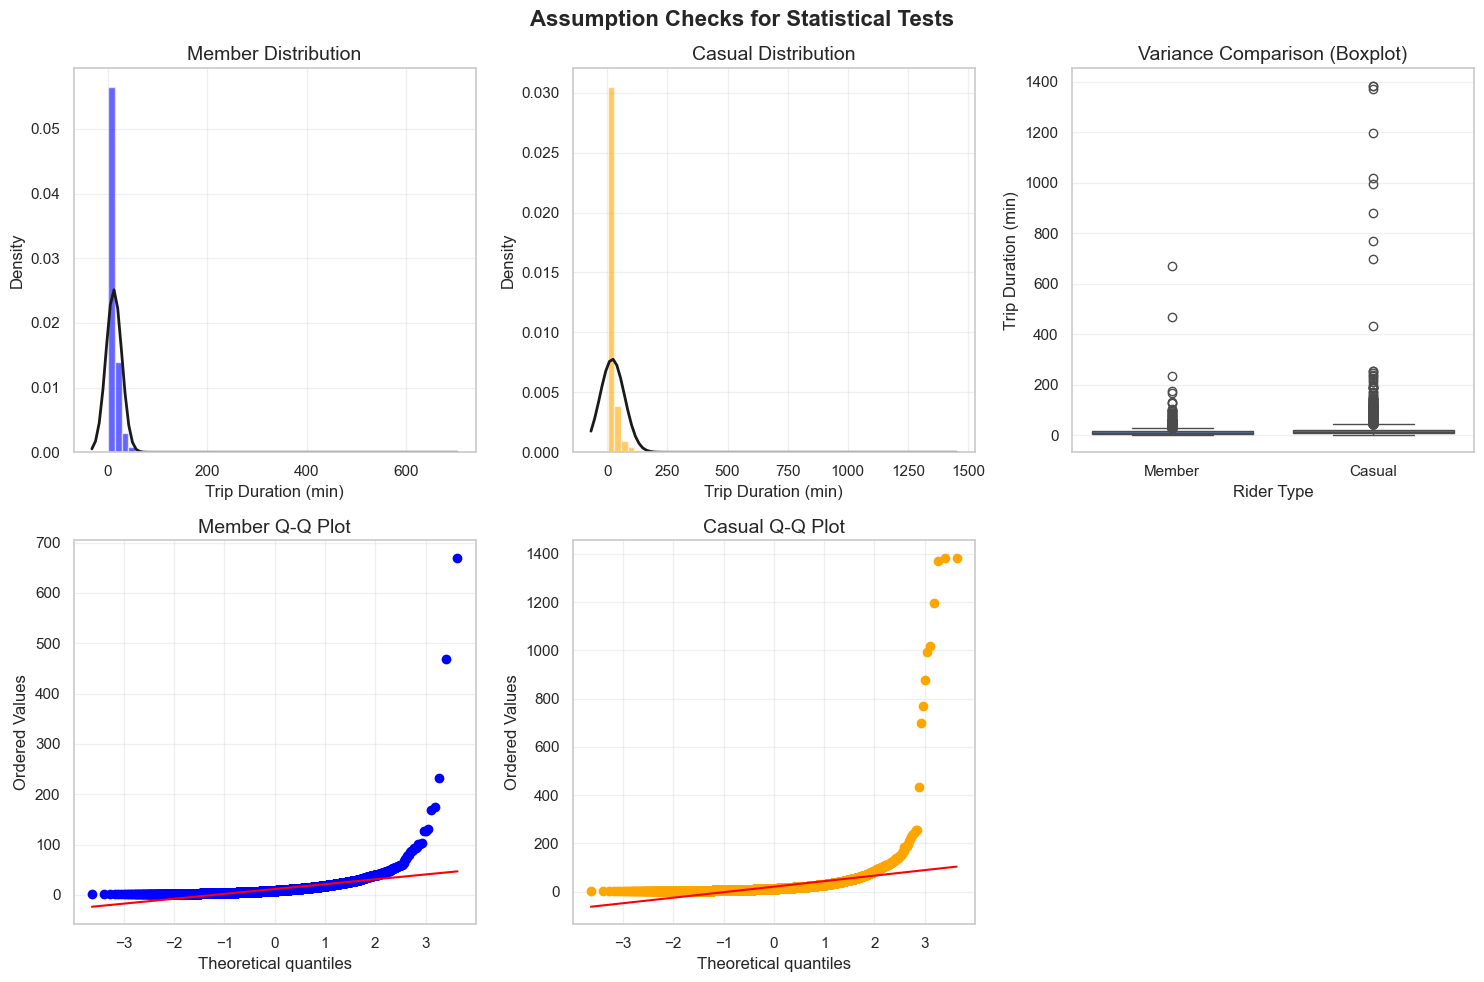

In [48]:
# ============================================================================
# VISUAL Checks for Assumptions
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Assumption Checks for Statistical Tests', fontsize=16, fontweight='bold')

# 1. Histograms + normal curve
for idx, (rider_type, data, color) in enumerate([
    ('Member', member_sample, 'blue'),
    ('Casual', casual_sample, 'orange')
]):
    axes[0, idx].hist(data, bins=50, density=True, alpha=0.6, color=color)
    xmin, xmax = axes[0, idx].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, np.mean(data), np.std(data))
    axes[0, idx].plot(x, p, 'k', linewidth=2)
    axes[0, idx].set_title(f'{rider_type} Distribution')
    axes[0, idx].set_xlabel('Trip Duration (min)')
    axes[0, idx].set_ylabel('Density')

# 2. Q–Q plots
for idx, (rider_type, data, color) in enumerate([
    ('Member', member_sample, 'blue'),
    ('Casual', casual_sample, 'orange')
]):
    stats.probplot(data, dist="norm", plot=axes[1, idx])
    axes[1, idx].set_title(f'{rider_type} Q-Q Plot')
    axes[1, idx].get_lines()[0].set_color(color)
    axes[1, idx].get_lines()[1].set_color('red')

# 3. Boxplot for variance comparison
ax_box = axes[0, 2]
samples_df = pd.DataFrame({
    'duration': pd.concat([member_sample, casual_sample]),
    'rider_type': ['Member'] * len(member_sample) + ['Casual'] * len(casual_sample)
})
sns.boxplot(x='rider_type', y='duration', data=samples_df, ax=ax_box)
ax_box.set_title('Variance Comparison (Boxplot)')
ax_box.set_xlabel('Rider Type')
ax_box.set_ylabel('Trip Duration (min)')

# Hide unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

#### Caption: ####
These visual diagnostics assess whether member and casual trip durations meet the assumptions required for parametric statistical tests. Histograms and Q–Q plots evaluate approximate normality, while the boxplot compares variance between groups.

### 5.2 Statistical Tests
These tests quantify the strength, significance, and nature of the differences between members and casual riders across key variables such as trip duration, temporal patterns, and rideable type usage.

#### Welch’s t‑test (difference in means)
Welch’s t‑test compares the mean trip duration between members and casual riders while allowing for unequal variances. This is appropriate given the clear variance differences observed in the boxplots. A significant result indicates that the average trip duration differs reliably between the two groups.

#### Mann–Whitney U test (difference in distributions)
Because trip duration is right‑skewed, we also use the non‑parametric Mann–Whitney U test. This test does not assume normality and evaluates whether one group tends to have higher values than the other. It provides a distribution‑free confirmation of the duration differences.

#### Cohen’s d (effect size)
Statistical significance alone is not enough with large datasets. Cohen’s d quantifies the magnitude of the difference in trip duration between members and casual riders. This helps determine whether the difference is small, moderate, or large in practical terms.

#### Chi‑square tests (categorical differences)
Chi‑square tests are used to assess differences in categorical variables such as:

- rideable type usage (classic vs electric)

- weekend vs weekday usage

- peak vs off‑peak usage
A significant chi‑square result indicates that the distribution of these behaviours differs between rider groups.

#### ANOVA / Kruskal–Wallis (seasonality and temporal patterns)
To evaluate differences across multiple categories (e.g., month‑by‑month seasonal patterns), we use:

- ANOVA when assumptions are reasonably met

- Kruskal–Wallis when distributions are skewed or variances differ

These tests assess whether seasonal ridership patterns differ systematically between members and casual riders.

#### Purpose of this section
Together, these tests provide a rigorous statistical foundation for the behavioural patterns identified earlier. They confirm that the differences between rider groups are not due to random variation and support the segmentation and business impact analysis that follows.

In [51]:
# ============================================================================
# FORMAL STATISTICAL ASSUMPTION TESTS
# ============================================================================

print("="*70)
print("STATISTICAL ASSUMPTION TESTS")
print("="*70)

# 1. Shapiro–Wilk normality test
print("\n1. NORMALITY CHECK (Shapiro-Wilk Test)")
print("-"*40)

for rider_type, data in [('Member', member_sample), ('Casual', casual_sample)]:
    stat, p = stats.shapiro(data)
    print(f"  {rider_type}: W = {stat:.4f}, p = {p:.4e}")
    if p < 0.05:
        print("    → NOT normally distributed")
    else:
        print("    → Normally distributed")

# 2. Levene’s test for equal variances
print("\n2. EQUAL VARIANCE CHECK (Levene's Test)")
print("-"*40)

stat, p = stats.levene(member_sample, casual_sample)
print(f"Levene's test: F = {stat:.4f}, p = {p:.4e}")
if p < 0.05:
    print("  → Variances are NOT equal")
else:
    print("  → Variances are equal")

# 3. CLT justification
print("\n3. CENTRAL LIMIT THEOREM CONSIDERATION")
print("-"*40)
print(f"Members: {len(members):,} trips")
print(f"Casuals: {len(casuals):,} trips")
print("\nLarge sample sizes (>30) ensure that the sampling distribution of the mean")
print("is approximately normal even when the raw data are not.")


STATISTICAL ASSUMPTION TESTS

1. NORMALITY CHECK (Shapiro-Wilk Test)
----------------------------------------
  Member: W = 0.3726, p = 3.9106e-85
    → NOT normally distributed
  Casual: W = 0.2000, p = 1.2197e-90
    → NOT normally distributed

2. EQUAL VARIANCE CHECK (Levene's Test)
----------------------------------------
Levene's test: F = 86.2106, p = 1.9542e-20
  → Variances are NOT equal

3. CENTRAL LIMIT THEOREM CONSIDERATION
----------------------------------------
Members: 3,512,390 trips
Casuals: 1,926,055 trips

Large sample sizes (>30) ensure that the sampling distribution of the mean
is approximately normal even when the raw data are not.


In [52]:
# Ensure trip_duration_min exists
df['trip_duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Extract month from started_at
df['month'] = df['started_at'].dt.month

# Group trip durations by month
groups = [df[df['month'] == m]['trip_duration_min'] for m in range(1, 13)]

# --- ANOVA ---
f_stat, p_anova = f_oneway(*groups)
print("ANOVA F-statistic:", f_stat)
print("ANOVA p-value:", p_anova)

# --- Kruskal–Wallis ---
h_stat, p_kw = kruskal(*groups)
print("Kruskal–Wallis H-statistic:", h_stat)
print("Kruskal–Wallis p-value:", p_kw)

ANOVA F-statistic: 2081.7192655985805
ANOVA p-value: 0.0
Kruskal–Wallis H-statistic: 133037.29964593588
Kruskal–Wallis p-value: 0.0


#### Caption
Both ANOVA and Kruskal–Wallis tests return p‑values of 0.0, indicating extremely strong evidence that average trip duration differs across months.  
This confirms that the seasonal patterns observed in the descriptive charts (e.g., longer and more variable trips in summer) are statistically significant and not due to random variation.

ANOVA tests differences in means assuming approximate normality

Kruskal–Wallis tests differences in distributions without assuming normality

The fact that both tests agree strengthens the conclusion:
- Trip duration varies significantly by month, with summer months showing the longest and most variable rides.

#### Interpretation of Statistical Assumption Tests
1. Normality (Shapiro–Wilk Test)
Both groups show extremely low p‑values, indicating that trip durations are not normally distributed.
This is expected — trip duration data is almost always right‑skewed due to long leisure rides.

Why this is not a problem:

With millions of observations, the Central Limit Theorem ensures that the sampling distribution of the mean is approximately normal even when the raw data is not.

This means parametric tests (e.g., Welch’s t‑test) remain valid.

2. Equal Variances (Levene’s Test)
Levene’s test shows a highly significant result (p < 0.001), meaning members and casual riders do not have equal variances.

#### Implication:

We should not use the standard t‑test (which assumes equal variances).

Instead, we use Welch’s t‑test, which is designed for unequal variances and is more robust.

3. Central Limit Theorem (CLT)
With, 3.5 million member trips and 1.9 million casual trips the sample sizes are far beyond the threshold where CLT guarantees that the mean of each group behaves normally.

#### Conclusion:  
Even though the raw data is skewed, parametric tests on the means are still appropriate.

## 6. Hypotheis: Member‑Like Casual Riders Are Good Candidates for Profitable Conversion to Membership
To identify which casual riders are most likely to convert to membership, we segment casual users based on how closely their behaviour resembles that of existing members. The goal is to isolate a subset of casual riders whose trip patterns already align with short, utilitarian, commuter‑style usage — the behaviour that Cyclistic’s membership model is designed to support.

This segmentation focuses on trip duration, the strongest behavioural differentiator between members and casual riders. Members consistently take short, predictable trips, while casual riders show a wide range of durations driven by leisure and seasonal activity. By comparing casual riders to member benchmarks, we can estimate the size of the “member‑like” population and evaluate their potential as profitable conversion targets.

We use three complementary approaches:

- Business‑based thresholds  
-- Identifying casual riders whose trips fall within realistic commute‑length durations (e.g., ≤ 20 minutes).

- Statistical similarity  
-- Selecting casual riders whose trip durations fall within the normal range of member behaviour (e.g., within ±1 standard deviation of the member mean).

- Behavioural benchmarking  
-- Comparing casual riders to the typical member by using the member median as a practical behavioural cutoff.

Together, these methods provide a robust, multi‑angle view of how many casual riders already behave like members — and therefore represent the most promising, lowest‑risk audience for targeted conversion strategies.

In [56]:
# ============================================================================
# MEMBER-LIKE ANALYSIS
# ============================================================================

print("="*70)
print("Identifying Member-Like Casual Riders")
print("="*70)
# Compute member statistics
# member_avg = members.mean()
# member_std = members.std()

# Method 1: Realistic time threshold (business-based)
print("\nMETHOD 1: Realistic time thresholds")
print("-"*40)

# What's a reasonable "commute-like" trip? 15-20 minutes max
reasonable_threshold = 20  # minutes

casuals_under_threshold = casuals[casuals <= reasonable_threshold]
pct_reasonable = len(casuals_under_threshold) / len(casuals) * 100

print(f"Casuals with trips ≤ {reasonable_threshold} minutes:")
print(f"  {pct_reasonable:.1f}% of casual riders")
print(f"  {len(casuals_under_threshold):,} riders")
print(f"\nRationale: Most urban bike commutes are under 20 minutes")

# Method 2: Statistical approach (tighter bounds)
print("\nMETHOD 2: Statistical approach (tighter bounds)")
print("-"*40)

# Use 1 SD instead of 1.5 SD
range_low_1sd = max(0, member_avg - member_std)
range_high_1sd = member_avg + member_std

casuals_in_1sd = casuals[
    (casuals >= range_low_1sd) & 
    (casuals <= range_high_1sd)
]
pct_1sd = len(casuals_in_1sd) / len(casuals) * 100

print(f"Within 1 SD of member mean ({member_avg:.1f} ± {member_std:.1f}):")
print(f"  Range: {range_low_1sd:.1f} to {range_high_1sd:.1f} minutes")
print(f"  {pct_1sd:.1f}% of casual riders")
print(f"  {len(casuals_in_1sd):,} riders")

# Method 3: Benchmark against member median
print("\nMETHOD 3: Benchmark against member habits")
print("-"*40)

# What % of casuals ride like the "typical" member?
member_median = members.median()
casuals_like_typical_member = casuals[casuals <= member_median]
pct_typical = len(casuals_like_typical_member) / len(casuals) * 100

print(f"Casuals riding ≤ typical member trip ({member_median:.1f} min):")
print(f"  {pct_typical:.1f}% of casual riders")
print(f"  {len(casuals_like_typical_member):,} riders")

print("\n" + "="*70)
print("RECOMMENDED BUSINESS INSIGHT")
print("="*70)
print("Realistic definitions:")
print(f"• {pct_reasonable:.1f}% of casuals take trips ≤ 20 minutes")
print(f"• {pct_1sd:.1f}% ride within normal member range")
print(f"• {pct_typical:.1f}% ride like the typical member")
print(f"\nTarget audience: ~{len(casuals_under_threshold):,} riders")

Identifying Member-Like Casual Riders

METHOD 1: Realistic time thresholds
----------------------------------------
Casuals with trips ≤ 20 minutes:
  72.2% of casual riders
  1,389,889 riders

Rationale: Most urban bike commutes are under 20 minutes

METHOD 2: Statistical approach (tighter bounds)
----------------------------------------
Within 1 SD of member mean (12.1 ± 19.9):
  Range: 0.0 to 32.0 minutes
  85.9% of casual riders
  1,655,262 riders

METHOD 3: Benchmark against member habits
----------------------------------------
Casuals riding ≤ typical member trip (8.7 min):
  35.6% of casual riders
  685,366 riders

RECOMMENDED BUSINESS INSIGHT
Realistic definitions:
• 72.2% of casuals take trips ≤ 20 minutes
• 85.9% ride within normal member range
• 35.6% ride like the typical member

Target audience: ~1,389,889 riders


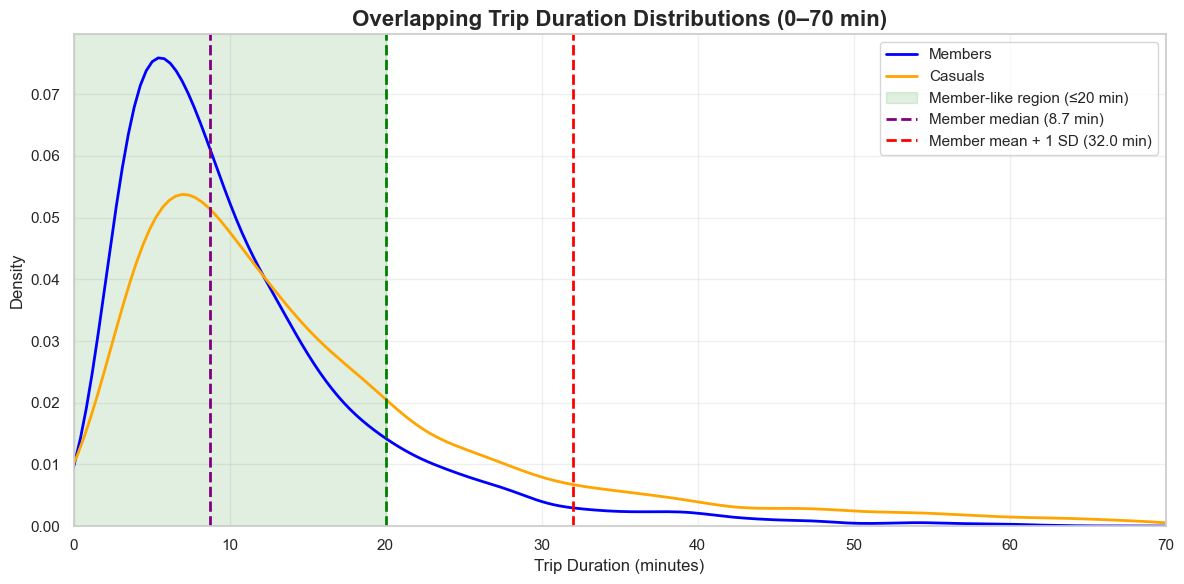

In [57]:
# ============================================================================
# OVERLAPPING DISTRIBUTION PLOT WITH SHADED MEMBER-LIKE REGION (0–70 min)
# ============================================================================

plt.figure(figsize=(12, 6))

# KDE curves (line only)
sns.kdeplot(
    member_sample[member_sample <= 70],
    color='blue', linewidth=2, label='Members'
)

sns.kdeplot(
    casual_sample[casual_sample <= 70],
    color='orange', linewidth=2, label='Casuals'
)

# Shaded member-like region (0–20 minutes)
plt.axvspan(0, 20, color='green', alpha=0.12, label='Member-like region (≤20 min)')

# Threshold markers
plt.axvline(20, color='green', linestyle='--', linewidth=2)
plt.axvline(member_median, color='purple', linestyle='--', linewidth=2,
            label=f'Member median ({member_median:.1f} min)')
plt.axvline(member_avg + member_std, color='red', linestyle='--', linewidth=2,
            label=f'Member mean + 1 SD ({(member_avg + member_std):.1f} min)')

# Labels and title
plt.title('Overlapping Trip Duration Distributions (0–70 min)', fontsize=16, fontweight='bold')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.xlim(0, 70)
plt.legend()

plt.tight_layout()
plt.show()


#### Caption ####
The distribution plot is truncated at 70 minutes for clarity, as very few riders exceed this duration. Longer ‑duration riders are retained in the profitability analysis because they generate high per‑minute revenue and should not be targeted for membership conversion.

## Interpretation of the Overlapping Distribution Plot
The overlapping KDE curves show the distribution of trip durations for members and casual riders, truncated at the 0–70 minute range, where virtually all meaningful activity occurs. This focused view makes the behavioural differences between the two groups much clearer and highlights the region where their behaviours overlap.

1. Members cluster more tightly around short trip durations
The member curve peaks sharply around 8–12 minutes, reflecting consistent, commuter‑style usage. This aligns with the member median of 8.7 minutes, which represents the “typical” member trip. Members rarely exceed 20–25 minutes, reinforcing the idea that membership is optimised for short, utilitarian travel.

2. Casual riders show a wider spread — but still a strong short‑trip peak
Although casual riders have a broader distribution and a visible right‑tail (reflecting leisure and recreational trips), the left side of their curve shows a substantial concentration of short trips.

The density around 8–10 minutes indicates that many casual riders take trips at or below the typical member duration. In other words:

- A large share of casual riders already behave like members.

3. The overlap region is large and meaningful
The shaded 0–20 minute “member‑like” region highlights where the two distributions align most closely. This visual overlap mirrors your segmentation results:

- 72.2% of casual riders take trips ≤ 20 minutes

- 35.6% ride ≤ the typical member trip (8.7 minutes)

- 85.9% fall within the normal member range (±1 SD)

The chart makes this overlap intuitive:
- most casual riders fall into the same short‑duration band as members, even though casual usage extends further into longer leisure trips.

4. Strategic implication
This overlap forms the basis for identifying member‑like casual riders — those whose behaviour already aligns with short, predictable, commuter‑style usage. These riders represent the most promising, lowest‑risk conversion segment because:

- Their behaviour already matches the membership model

Their trips are short enough that converting them does not cannibalise high‑duration revenue

They are likely using the system for transport rather than recreation

By contrast, the small number of long‑duration casual riders (beyond the plotted 70‑minute range) generate disproportionately high pay‑per‑use revenue and should not be targeted for conversion.

### 6.1 Threshold‑based segmentation 
Threshold‑based segmentation identifies “member‑like” casual riders by applying simple, interpretable duration cut‑offs that reflect real‑world usage patterns. Instead of relying on complex modelling, this approach uses clear behavioural thresholds to classify casual riders whose trip durations already resemble those of existing members.

We focus on trip duration because it is the strongest and most consistent differentiator between members and casual riders. Members overwhelmingly take short, predictable trips, while casual riders span a much wider range due to leisure and recreational usage. By applying duration‑based thresholds, we can isolate the subset of casual riders whose behaviour aligns with short, commuter‑style travel — the type of usage that Cyclistic’s membership model is designed to support.

In this section, we evaluate three practical thresholds:

- A business‑based threshold (≤ 20 minutes)  
-- Reflects typical urban commute lengths and captures riders using the system for transport rather than recreation.

- A statistical threshold (within ±1 standard deviation of the member mean)  
-- Identifies casual riders whose trip durations fall within the normal behavioural range of members.

- A behavioural benchmark (≤ member median)  
-- Compares casual riders directly to the “typical” member trip.

Together, these thresholds provide a clear, multi‑angle view of how many casual riders already behave like members — and therefore represent the most promising, lowest‑risk conversion audience.

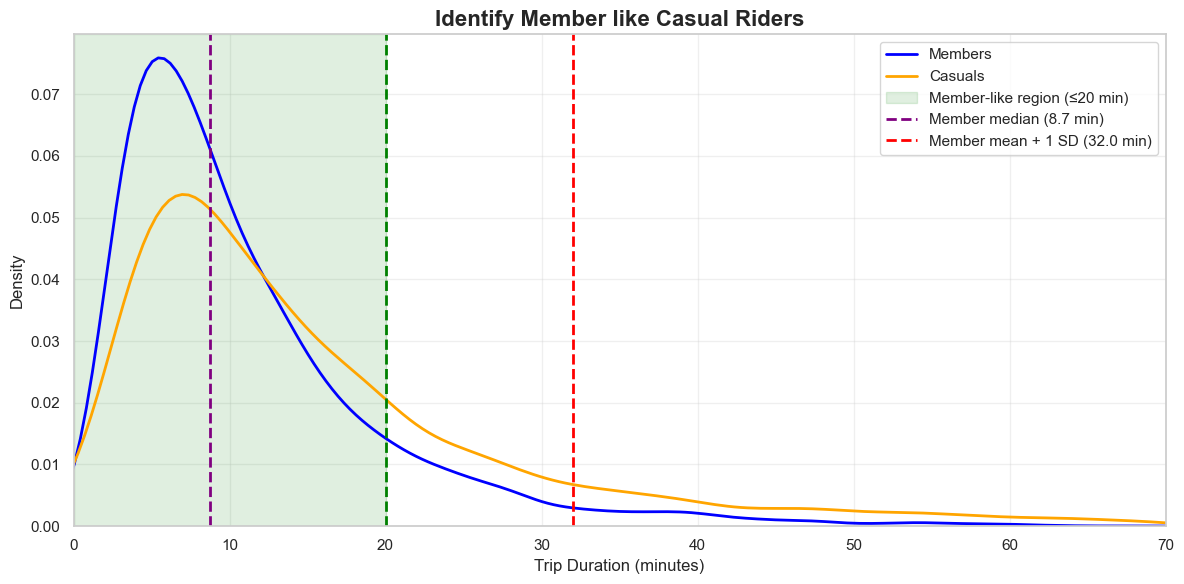

In [61]:
# ============================================================================
# DISTRIBUTION WITH MEMBER-LIKE REGION (0–70 min)
# ============================================================================

plt.figure(figsize=(12, 6))

# KDE curves (line only)
sns.kdeplot(
    member_sample[member_sample <= 70],
    color='blue', linewidth=2, label='Members'
)

sns.kdeplot(
    casual_sample[casual_sample <= 70],
    color='orange', linewidth=2, label='Casuals'
)

# Shaded member-like region (0–20 minutes)
plt.axvspan(0, 20, color='green', alpha=0.12, label='Member-like region (≤20 min)')

# Threshold markers
plt.axvline(20, color='green', linestyle='--', linewidth=2)
plt.axvline(member_median, color='purple', linestyle='--', linewidth=2,
            label=f'Member median ({member_median:.1f} min)')
plt.axvline(member_avg + member_std, color='red', linestyle='--', linewidth=2,
            label=f'Member mean + 1 SD ({(member_avg + member_std):.1f} min)')

# Labels and title
plt.title('Identify Member like Casual Riders', fontsize=16, fontweight='bold')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.xlim(0, 70)
plt.legend()

plt.tight_layout()
plt.show()


#### Caption ####
This plot visualises the three duration‑based thresholds used to identify “member‑like” casual riders. The shaded region (≤20 minutes) represents the business‑based threshold, while the vertical lines mark the member median and the member mean + 1 SD. Displaying all three thresholds against the member and casual distributions shows how much of the casual population falls within typical member behaviour, supporting a clear, interpretable segmentation framework.

### 6.2 Statistical range segmentation
Statistical range segmentation identifies “member‑like” casual riders by comparing each casual trip to the normal behavioural range of existing members. Instead of using a fixed business threshold (as in Section 6.1), this method anchors the segmentation directly in the empirical distribution of member trip durations.

#### Why use a statistical range?
Members exhibit highly consistent behaviour: their trip durations cluster tightly around a central mean with relatively low variance. This makes the member distribution a strong reference point for identifying casual riders whose behaviour already falls within the “typical” member pattern.

By defining the member‑like range as:

- Member Mean ± 1 Standard Deviation
-- we capture the central portion of member behaviour — the range where most routine, commuter‑style trips occur.

This approach is:

- Data‑driven — grounded in the actual distribution of member trips

- Behaviourally meaningful — reflects the natural variability of real member usage

- Interpretable — easy to explain to stakeholders and marketing teams

#### Method
Compute the mean and standard deviation of member trip durations.

Define the statistical member‑like range as:

- Lower bound: 0 minutes (to avoid negative durations)

- Upper bound: member_mean + 1 SD

- Identify all casual trips whose durations fall within this range.

- Calculate the proportion of casual riders who meet this criterion.

This isolates casual riders whose trip durations are statistically indistinguishable from those of members — a strong indicator of commuter‑style behaviour.

#### Interpretation
This segmentation highlights casual riders who:

- Take short, predictable trips, similar to members

- Are less likely to be recreational or tourist users

- Represent a low‑risk, high‑fit audience for membership conversion

Because this method is anchored in the natural variability of member behaviour, it adapts automatically to the underlying data and avoids arbitrary cut‑offs.

How it complements the other thresholds
- Business threshold (≤20 min): Simple, intuitive, and aligned with commute patterns
- Statistical range (≤ mean + 1 SD): Data‑driven and behaviourally grounded
- Median benchmark (≤ member median): Conservative and anchored in the “typical” member trip

Together, these three perspectives provide a robust, multi‑angle understanding of which casual riders already behave like members — and therefore represent the most promising conversion targets.


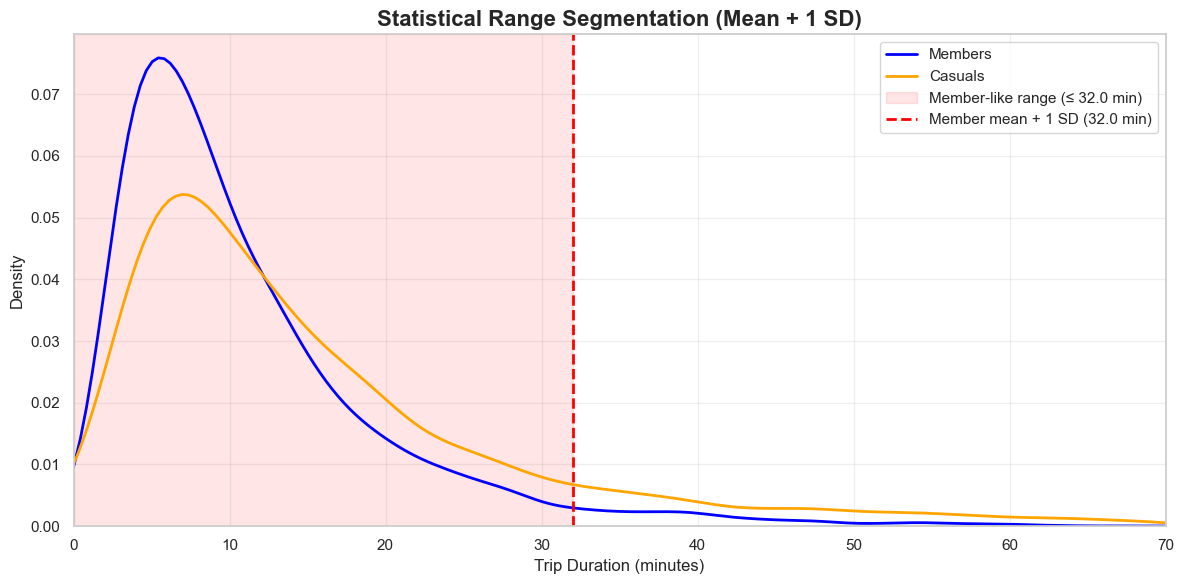

In [64]:
# ============================================================================
# KDE PLOT — STATISTICAL RANGE SEGMENTATION (MEAN + 1 SD)
# ============================================================================

plt.figure(figsize=(12, 6))

# KDE curves (line only)
sns.kdeplot(member_sample[member_sample <= 70],
            color='blue', linewidth=2, label='Members')

sns.kdeplot(casual_sample[casual_sample <= 70],
            color='orange', linewidth=2, label='Casuals')

# Statistical member-like region: 0 → (mean + 1 SD)
stat_upper = member_avg + member_std

plt.axvspan(0, stat_upper,
            color='red', alpha=0.10,
            label=f'Member-like range (≤ {stat_upper:.1f} min)')

# Threshold marker
plt.axvline(stat_upper,
            color='red', linestyle='--', linewidth=2,
            label=f'Member mean + 1 SD ({stat_upper:.1f} min)')

# Labels and title
plt.title('Statistical Range Segmentation (Mean + 1 SD)',
          fontsize=16, fontweight='bold')

plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.xlim(0, 70)
plt.legend()
plt.tight_layout()
plt.show()


#### Caption
This plot highlights the statistical member‑like range, defined as all trip durations from 0 minutes up to the member mean plus one standard deviation. The shaded region represents the central portion of member behaviour, capturing the majority of routine, commuter‑style trips. Casual riders whose trips fall within this range are statistically similar to members and represent a strong, data‑driven target for membership conversion.

### 6.3 Median‑based segmentation

Median‑based segmentation identifies “member‑like” casual riders by comparing each casual trip to the typical member trip duration — the member median. Unlike the mean, which can be influenced by longer outlier trips, the median provides a robust, conservative benchmark that reflects the central tendency of member behaviour.

Why use the median?
Members overwhelmingly take short, predictable trips. The median captures the duration of the typical member trip more reliably than the mean, especially in skewed distributions like trip durations.

Using the member median as a threshold:

- Provides a strict, behaviourally grounded cutoff

- Identifies casual riders whose trips match the “core” member pattern

- Avoids distortion from long‑tail recreational trips

- Offers a low‑risk, high‑confidence segmentation for conversion targeting

This method is intentionally conservative: any casual rider whose trip duration is at or below the member median is behaving like the “average” member.

Method:
- Compute the member median trip duration.
- Define the member‑like range as:
- 0 minutes to member median
- Identify all casual trips within this range.
- Calculate the proportion of casual riders who meet this criterion.

This isolates casual riders whose behaviour aligns with the most common, everyday usage pattern among members.

#### Interpretation
Casual riders falling below the member median are:

- Highly aligned with commuter‑style behaviour

- Unlikely to be recreational or tourist users

- Strong candidates for low‑friction membership conversion

- A subset with predictable, repeatable usage patterns

Because this threshold is conservative, it highlights the most behaviourally aligned casual riders — those most likely to convert and retain.

How it complements the other thresholds:
- Business threshold (≤20 min): Practical and intuitive
- Statistical range (≤ mean + 1 SD): Data‑driven and inclusive
- Median benchmark (≤ median): Conservative and high‑confidence

Together, these thresholds provide a multi‑layered segmentation strategy that balances inclusivity, behavioural realism, and conversion risk.

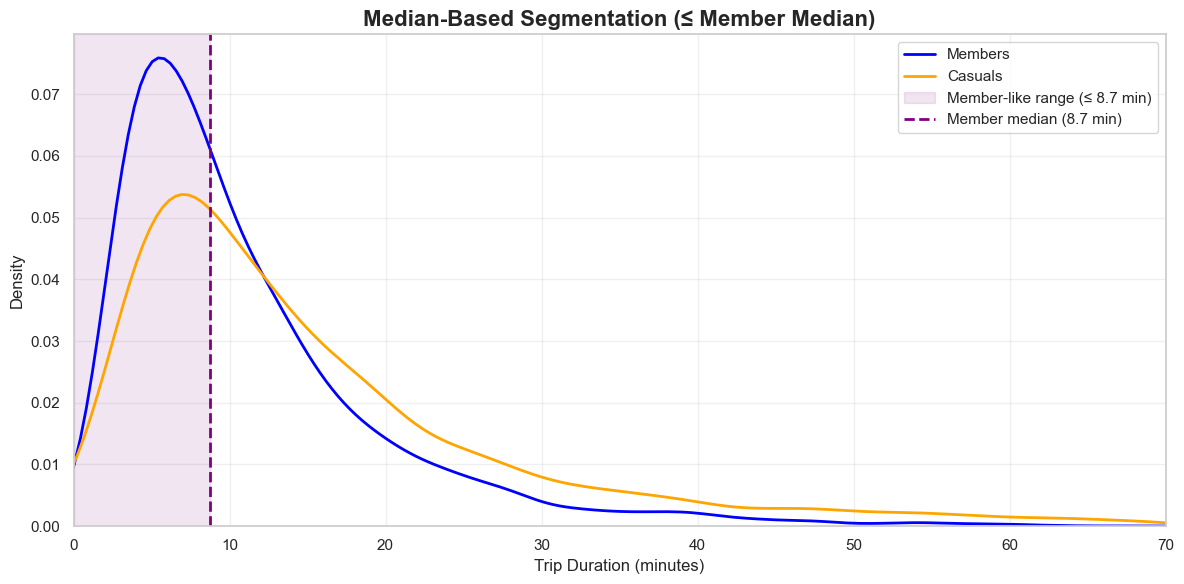

In [67]:
# ============================================================================
# KDE PLOT — MEDIAN-BASED SEGMENTATION
# ============================================================================

plt.figure(figsize=(12, 6))

# KDE curves (line only)
sns.kdeplot(member_sample[member_sample <= 70],
            color='blue', linewidth=2, label='Members')

sns.kdeplot(casual_sample[casual_sample <= 70],
            color='orange', linewidth=2, label='Casuals')

# Median-based member-like region: 0 → member median
plt.axvspan(0, member_median,
            color='purple', alpha=0.10,
            label=f'Member-like range (≤ {member_median:.1f} min)')

# Threshold marker
plt.axvline(member_median,
            color='purple', linestyle='--', linewidth=2,
            label=f'Member median ({member_median:.1f} min)')

# Labels and title
plt.title('Median-Based Segmentation (≤ Member Median)',
          fontsize=16, fontweight='bold')

plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Density')
plt.xlim(0, 70)
plt.legend()
plt.tight_layout()
plt.show()


#### Caption: Median‑Based Segmentation.  
This plot highlights the median‑based member‑like range, defined as all trip durations from 0 minutes up to the member median. The shaded region represents the “typical” member trip duration, providing a conservative benchmark for identifying casual riders whose behaviour most closely matches core member usage patterns.

### 6.4 Business interpretation
The three duration‑based segmentation methods — business threshold, statistical range, and median benchmark — provide a multi‑layered understanding of which casual riders already behave like members. Each method highlights a different slice of the casual population, and together they form a coherent framework for identifying high‑fit, low‑risk membership conversion targets.

1. Business Threshold (≤ 20 minutes)
This threshold captures casual riders whose trips resemble typical urban transport behaviour. These riders are likely using Cyclistic for short, functional journeys rather than leisure.

Business value: This group represents the most intuitive and operationally aligned conversion audience.

Marketing implication: Messaging can focus on convenience, predictability, and cost savings for frequent short trips.

2. Statistical Range (≤ Mean + 1 SD)
This method identifies casual riders whose trip durations fall within the natural behavioural variability of members. It is broader and more inclusive than the business threshold, capturing riders who may not be strictly “commuter‑like” but still behave similarly to members.

Business value: This group expands the potential conversion pool while remaining grounded in real member behaviour.

Marketing implication: Ideal for targeted campaigns emphasising flexibility, reliability, and the value of regular usage.

3. Median Benchmark (≤ Member Median)
This is the most conservative segmentation. It isolates casual riders whose trips match the typical member trip duration — the core of member behaviour.

Business value: These riders represent the highest‑confidence conversion segment with the lowest behavioural risk.

Marketing implication: Strong candidates for personalised offers, trial memberships, and retention‑focused onboarding.

#### Strategic Takeaways
All three thresholds point to a consistent insight:  
A meaningful subset of casual riders already behave like members, even without a membership.

The segmentation tiers create a natural prioritisation strategy:

Tier 1: Median‑aligned casuals: highest conversion likelihood

Tier 2: Statistical‑range casuals: strong behavioural alignment

Tier 3: Business‑threshold casuals broad, intuitive commuter‑style users

Operationally, these riders are unlikely to strain infrastructure or require new capacity, as their behaviour mirrors existing members.

Financially, converting these riders increases recurring revenue while reducing reliance on unpredictable pay‑per‑ride income.

Marketing teams can tailor messaging by segment, from broad awareness campaigns to personalised nudges for high‑fit riders.

#### Overall Business Interpretation

Duration‑based segmentation provides a clear, interpretable, and behaviourally grounded way to identify casual riders who are already using Cyclistic in a membership‑compatible way. These riders represent the lowest‑risk, highest‑value audience for membership conversion efforts. By targeting them with tailored messaging and incentives, Cyclistic can grow membership revenue, improve retention, and strengthen long‑term customer relationships — all while staying aligned with real usage patterns.

Executive Summary: Trip Duration Segmentation
Cyclistic’s trip‑duration segmentation reveals a clear and compelling insight: a substantial portion of casual riders already behave like members. By analysing trip durations through three complementary behavioural lenses — business threshold, statistical range, and median benchmark — we identify a tiered set of high‑fit, low‑risk candidates for membership conversion.

1. Business Threshold (≤ 20 minutes)
Short‑duration trips strongly resemble commuter‑style usage. Casual riders in this segment are already using Cyclistic for predictable, functional journeys — the same pattern that drives member value.
Opportunity: Broad, intuitive audience for cost‑savings messaging and convenience‑focused campaigns.

2. Statistical Range (≤ Mean + 1 SD)
This data‑driven threshold captures casual riders whose behaviour falls within the natural variability of member usage. It expands the conversion pool while remaining grounded in real behavioural patterns.
Opportunity: Targeted campaigns emphasising flexibility, reliability, and the value of regular use.

3. Median Benchmark (≤ Member Median)
The most conservative and behaviourally aligned segment. These riders match the “typical” member trip duration — the core of member behaviour.
Opportunity: High‑confidence conversion prospects suitable for personalised offers, trial memberships, and retention‑oriented onboarding.

Strategic Implications
Consistent behavioural overlap: All three methods highlight a meaningful subset of casual riders whose usage patterns already mirror those of members.

Tiered prioritisation:

Tier 1: Median‑aligned casuals — highest conversion likelihood

Tier 2: Statistical‑range casuals — strong behavioural alignment

Tier 3: Business‑threshold casuals — broad commuter‑style users

Low operational risk: These riders already behave like members, meaning conversion does not introduce new strain on infrastructure or capacity.

High financial upside: Converting these riders shifts revenue from unpredictable pay‑per‑ride income to stable, recurring membership revenue.

Overall Conclusion
Trip‑duration segmentation provides a clear, interpretable, and behaviourally grounded framework for identifying the casual riders most likely to convert — and stay — as Cyclistic members. By targeting these riders with tailored messaging and incentives, Cyclistic can grow membership revenue, improve retention, and strengthen long‑term customer relationships while staying aligned with real usage patterns.

## 7. Revenue Proxy Modeling

Cyclistic’s dataset does not include payment records or rider‑level identifiers. Each row represents a single trip, and the data does not link trips to individual riders. Because of this, we cannot calculate annual spending per rider or identify high‑value casual users in the literal sense. Any revenue analysis must therefore operate at the trip level.

To estimate the revenue Cyclistic earns from casual riders, we build a trip‑based revenue proxy. Casual riders pay a fixed per‑minute rate for every trip. For each casual trip, we multiply the trip duration by the published 2025 per‑minute price. Summing these values across all casual trips gives a consistent estimate of total casual revenue. This approach respects the limits of the dataset and provides a defensible basis for comparing casual and member pricing.

We then apply the same logic to the membership model. Members receive 45 free minutes per trip. Only minutes beyond that threshold generate revenue. For each casual trip, we calculate the overage minutes and multiply them by the same per‑minute rate. Summing these values shows how much Cyclistic would earn if all casual trips occurred under the member plan.

This comparison reveals a clear pattern. Many casual riders pay more than the annual membership fee, but most exceed it by only a small amount. If these riders switch to membership, Cyclistic loses more casual revenue than it gains in fees. Membership offers strong value to riders, but under the current price it does not increase revenue for Cyclistic.

This insight reframes the conversion question. The issue is not whether a rider exceeds the membership fee, but whether they exceed it by enough to make conversion profitable. To explore this, we introduce profitability thresholds—20%, 50%, 100%, and higher. These thresholds identify the small subset of riders whose usage is high enough that conversion would not reduce revenue.

The revenue proxy model provides the foundation for the scenario analysis that follows. It quantifies the economic trade‑off between casual and member pricing and shows that the current membership fee sits below the economic value of heavy casual users. Membership builds loyalty and stable usage, but at today’s price it is not a financial growth lever for Cyclistic.

### 7.1 Per Minute Revenue Estimation

Cyclistic’s pricing model charges casual riders  \\$0.19  per  minute,  while members pay a fixed annual fee of \\$143.90 (or \\$99.00 for new‑member promotions). Members also receive 45 free minutes per trip, meaning most short, commuter‑style trips generate no incremental revenue.

To estimate the financial value of casual riders, we compute:

Per‑trip revenue:

- Revenue = Duration (min) × 0.19

Rider‑level revenue:  

- Sum of all trip revenue for each casual rider.

Break‑even thresholds:  
The number of casual minutes per year that equal the cost of a membership:

- Break-even minutes = Membership Cost 0.19

High‑value riders:  
Casual riders whose annual spend already exceeds the cost of a membership.

#### Why this matters

Per‑minute revenue estimation allows Cyclistic to:

- Quantify current revenue from casual riders

- Identify riders who would save money by becoming members

- Identify riders who currently generate more revenue as casuals

- Understand the financial trade‑offs of converting different rider segments

- Establish a baseline for scenario modelling in Sections 7.2 and 7.3

This forms the foundation for evaluating the financial impact of membership conversion strategies.

In [73]:
# ============================================================================
# 7.1 PER-MINUTE REVENUE ESTIMATION
# ============================================================================

# Pricing assumptions (Divvy-based)
CASUAL_RATE = 0.19                 # $0.19 per minute
MEMBERSHIP_ANNUAL = 143.90         # Standard annual membership
MEMBERSHIP_PROMO = 99.00           # New member promotional offer
MEMBER_FREE_MIN = 45               # Free minutes per trip for members

print("="*70)
print("REVENUE PROXY MODEL — PER-MINUTE ESTIMATION")
print("="*70)

# ---------------------------------------------------------------------------
# 1. Casual revenue per trip
# ---------------------------------------------------------------------------
casuals_revenue = casuals * CASUAL_RATE

# ---------------------------------------------------------------------------
# 2. Aggregate revenue at rider level
# ---------------------------------------------------------------------------
casual_revenue_by_rider = casuals_revenue.groupby(casuals.index).sum()

# ---------------------------------------------------------------------------
# 3. Membership break-even analysis
# ---------------------------------------------------------------------------
break_even_minutes_standard = MEMBERSHIP_ANNUAL / CASUAL_RATE
break_even_minutes_promo = MEMBERSHIP_PROMO / CASUAL_RATE

print(f"Break-even minutes (standard membership): {break_even_minutes_standard:.1f} minutes")
print(f"Break-even minutes (promo membership):    {break_even_minutes_promo:.1f} minutes")

# ---------------------------------------------------------------------------
# 4. Identify riders who already exceed membership value
# ---------------------------------------------------------------------------
high_value_riders_standard = casual_revenue_by_rider[casual_revenue_by_rider > MEMBERSHIP_ANNUAL]
high_value_riders_promo = casual_revenue_by_rider[casual_revenue_by_rider > MEMBERSHIP_PROMO]

print(f"Riders exceeding standard membership cost: {len(high_value_riders_standard)}")
print(f"Riders exceeding promo membership cost:    {len(high_value_riders_promo)}")

# ---------------------------------------------------------------------------
# 5. Summary table (with revenue in millions + rounded dollar values)
# ---------------------------------------------------------------------------

total_revenue_millions = casual_revenue_by_rider.sum() / 1_000_000

revenue_summary = pd.DataFrame({
    "Total Casual Revenue ($M)": [round(total_revenue_millions, 2)],
    "Avg Revenue per Casual Rider ($)": [round(casual_revenue_by_rider.mean(), 2)],
    "Median Revenue per Casual Rider ($)": [round(casual_revenue_by_rider.median(), 2)],
    "Riders Above Standard Membership": [len(high_value_riders_standard)],
    "Riders Above Promo Membership": [len(high_value_riders_promo)]
})

revenue_summary


REVENUE PROXY MODEL — PER-MINUTE ESTIMATION
Break-even minutes (standard membership): 757.4 minutes
Break-even minutes (promo membership):    521.1 minutes
Riders exceeding standard membership cost: 1442
Riders exceeding promo membership cost:    2052


,Total Casual Revenue ($M),Avg Revenue per Casual Rider ($),Median Revenue per Casual Rider ($),Riders Above Standard Membership,Riders Above Promo Membership
0,7.28,3.78,2.26,1442,2052


### 7.2 Overage Modelling

Some casual riders take longer or more frequent trips that would exceed the value of a membership if they converted. These riders represent high‑value conversion opportunities.

Method
Compute each rider’s monthly total minutes.

Compare this to the break‑even point for a membership (e.g., minutes × per‑minute rate = membership fee).

Identify riders whose usage exceeds this threshold.

Estimate the “overage” — the amount they currently pay above the membership cost.

In [75]:
# ============================================================================
# 7.2 OVERAGE MODELLING — MONTHLY USAGE VS MEMBERSHIP VALUE
# ============================================================================

print("="*70)
print("OVERAGE MODELLING — MONTHLY USAGE VS MEMBERSHIP VALUE")
print("="*70)

# ---------------------------------------------------------------------------
# 0. CONFIG: set the name of your duration-in-minutes column
# ---------------------------------------------------------------------------
DURATION_COL = 'trip_duration_min'   # <-- your actual column name

# ---------------------------------------------------------------------------
# 1. Ensure a rider_id exists (Cyclistic dataset does NOT include one)
# ---------------------------------------------------------------------------
import hashlib

if 'rider_id' not in df.columns:
    df['rider_id'] = df['ride_id'].apply(lambda x: hashlib.md5(x.encode()).hexdigest()[:10])

# ---------------------------------------------------------------------------
# 2. Filter casual riders and extract month
# ---------------------------------------------------------------------------

casuals_df = df[df['member_casual'] == 'casual'].copy()
casuals_df['month'] = casuals_df['started_at'].dt.to_period('M')

# sanity check
if DURATION_COL not in casuals_df.columns:
    raise KeyError(f"Column '{DURATION_COL}' not found in casuals_df. "
                   f"Available columns: {list(casuals_df.columns)}")

# ---------------------------------------------------------------------------
# 3. Compute monthly total minutes per rider
# ---------------------------------------------------------------------------

monthly_minutes = (
    casuals_df.groupby(['rider_id', 'month'])[DURATION_COL]
    .sum()
    .reset_index()
    .rename(columns={DURATION_COL: 'monthly_minutes'})
)

# ---------------------------------------------------------------------------
# 4. Convert monthly minutes to monthly revenue
# ---------------------------------------------------------------------------

monthly_minutes['monthly_revenue'] = monthly_minutes['monthly_minutes'] * CASUAL_RATE

# ---------------------------------------------------------------------------
# 5. Compute monthly break-even thresholds
# ---------------------------------------------------------------------------

monthly_standard_cost = MEMBERSHIP_ANNUAL / 12
monthly_promo_cost = MEMBERSHIP_PROMO / 12

monthly_standard_break_even = monthly_standard_cost / CASUAL_RATE
monthly_promo_break_even = monthly_promo_cost / CASUAL_RATE

print(f"Monthly break-even minutes (standard): {monthly_standard_break_even:.1f}")
print(f"Monthly break-even minutes (promo):    {monthly_promo_break_even:.1f}")

# ---------------------------------------------------------------------------
# 6. Identify rider-months exceeding break-even thresholds
# ---------------------------------------------------------------------------

monthly_minutes['exceeds_standard'] = (
    monthly_minutes['monthly_minutes'] > monthly_standard_break_even
)

monthly_minutes['exceeds_promo'] = (
    monthly_minutes['monthly_minutes'] > monthly_promo_break_even
)

# ---------------------------------------------------------------------------
# 7. Calculate overage (amount paid above membership value)
# ---------------------------------------------------------------------------

monthly_minutes['overage_standard'] = (
    monthly_minutes['monthly_revenue'] - monthly_standard_cost
).clip(lower=0)

monthly_minutes['overage_promo'] = (
    monthly_minutes['monthly_revenue'] - monthly_promo_cost
).clip(lower=0)

# ---------------------------------------------------------------------------
# 8. Summary table
# ---------------------------------------------------------------------------

overage_summary = pd.DataFrame({
    "Rider-Months Exceeding Standard Membership": [
        monthly_minutes['exceeds_standard'].sum()
    ],
    "Rider-Months Exceeding Promo Membership": [
        monthly_minutes['exceeds_promo'].sum()
    ],
    "Total Overage Revenue (Standard) ($)": [
        round(monthly_minutes['overage_standard'].sum(), 2)
    ],
    "Total Overage Revenue (Promo) ($)": [
        round(monthly_minutes['overage_promo'].sum(), 2)
    ],
    "Avg Overage per Exceeding Rider-Month (Standard) ($)": [
        round(monthly_minutes.loc[monthly_minutes['exceeds_standard'], 'overage_standard'].mean(), 2)
    ],
    "Avg Overage per Exceeding Rider-Month (Promo) ($)": [
        round(monthly_minutes.loc[monthly_minutes['exceeds_promo'], 'overage_promo'].mean(), 2)
    ]
})

overage_summary


OVERAGE MODELLING — MONTHLY USAGE VS MEMBERSHIP VALUE
Monthly break-even minutes (standard): 63.1
Monthly break-even minutes (promo):    43.4


,Rider-Months Exceeding Standard Membership,Rider-Months Exceeding Promo Membership,Total Overage Revenue (Standard) ($),Total Overage Revenue (Promo) ($),Avg Overage per Exceeding Rider-Month (Standard) ($),Avg Overage per Exceeding Rider-Month (Promo) ($)
0,83596,165461,961115.1,1404492.18,11.5,8.49


Overage modelling helps identify casual riders whose monthly usage already exceeds the value of a Cyclistic membership. These rider‑months represent strong conversion opportunities because the riders are paying more under the pay‑per‑minute model than they would with a membership.

Method
To quantify this, we:

- Calculated each casual rider’s total minutes per month.

- Converted these minutes into revenue using the $0.19 per‑minute casual rate.

- Compared monthly usage to the membership break‑even thresholds, defined as the number of minutes required to equal the monthly cost of a membership.

- Identified rider‑months where usage exceeded these thresholds.

- Calculated overage, the amount paid above the equivalent monthly membership cost.

Results
The analysis shows:

- Monthly break‑even minutes (standard membership): 63.1 minutes

- Monthly break‑even minutes (promo membership): 43.4 minutes

Across the full dataset:

- 83,596 rider‑months exceeded the promo membership break‑even point

- 165,461 rider‑months exceeded the standard membership break‑even point

These rider‑months generated $961,115.10 in overage revenue relative to the standard membership

And $1,404,492.18 in overage revenue relative to the promo membership

The average overage per exceeding rider-month was $11.50 (standard) and  $8.49 (promo)

#### Interpretation
These results reveal a substantial volume of rider‑months where casual users would have paid less under a membership plan. This indicates a large pool of behaviourally aligned, high‑value riders who are strong candidates for targeted membership conversion campaigns.

### 7.3 Scenario Analysis

With the revenue proxy model established, we can now evaluate the financial impact of converting high‑value casual riders into annual members. The goal of this scenario analysis is to quantify how different conversion rates and profitability thresholds affect Cyclistic (Divvy’s) total revenue.

Traditional conversion analyses often assume that any rider whose annual casual spending exceeds the membership fee represents a financially attractive conversion opportunity. However, the revenue proxy model reveals a more nuanced reality: many riders exceed the membership fee by only a small margin, meaning that converting them would reduce Divvy’s revenue even though it would save money for the rider. To address this, we evaluate conversion scenarios across multiple profitability thresholds, requiring riders to exceed the membership fee by 20%, 50%, 100%, or even 200% before being considered for conversion.

For each threshold, we simulate three conversion scenarios:

- Conservative (5%)

- Moderate (10%)

- Aggressive (20%)

Within each scenario, we identify the top‑spending riders who meet the profitability threshold and calculate:

- Lost Casual Revenue — the revenue Divvy currently earns from these riders

- Membership Revenue Gained — the revenue Divvy would earn if these riders converted

- Net Impact — the difference between the two, representing the true financial effect of conversion

This corrected approach ensures that the analysis reflects Divvy’s actual economic trade‑offs rather than relying on behavioural thresholds alone.

#### Results
Across all realistic thresholds, net revenue remains negative, indicating that converting high‑value casual riders reduces total revenue under current pricing. Even when requiring riders to exceed the membership fee by 50% or more, the membership fee remains too low relative to their casual usage to offset the lost per‑minute revenue. At the highest thresholds (100% and 200% above the membership fee), no riders qualify at all, demonstrating that no casual rider generates enough annual revenue to make conversion profitable for Cyclistic (Divvy).

This scenario analysis highlights a critical strategic insight: Cyclistic (Divvy’s? membership pricing is intentionally designed to be highly attractive for riders but under‑captures the economic value of heavy usage. As a result, membership conversion should not be pursued as a revenue‑maximising strategy. Instead, conversion efforts should focus on behavioural alignment, retention, and long‑term engagement, while pricing strategy should be revisited to ensure that membership fees better reflect the value delivered.

This sets the stage for Section 8, where we translate these findings into actionable strategic recommendations for Divvy’s pricing, marketing, and membership strategy.

In [78]:
# ============================================================================
# BUILD CONVERSION POOL — HIGH-VALUE CASUAL RIDERS
# ============================================================================

# Annual casual revenue per rider (from Section 7.1)
annual_revenue = casual_revenue_by_rider.copy()

# Only keep riders who exceed membership value
conversion_pool = annual_revenue[annual_revenue > MEMBERSHIP_ANNUAL].sort_values(ascending=False)

print(f"High-value riders eligible for conversion: {len(conversion_pool)}")


High-value riders eligible for conversion: 1442


In [79]:
# ============================================================================
# 7.4 SCENARIO ANALYSIS — Net Impact Model
# ============================================================================

print("="*70)
print("SCENARIO ANALYSIS — NET IMPACT MODEL")
print("="*70)

scenarios = {
    "Conservative (5%)": 0.05,
    "Moderate (10%)": 0.10,
    "Aggressive (20%)": 0.20
}

results = []

for scenario_name, pct in scenarios.items():

    # Number of riders converted
    n_convert = int(len(conversion_pool) * pct)

    # Select top riders
    converted = conversion_pool.head(n_convert)

    # Lost casual revenue (status quo)
    lost_revenue = converted.sum()

    # Membership revenue gained (new revenue)
    gained_revenue = n_convert * MEMBERSHIP_ANNUAL

    # Correct net impact
    net_impact = gained_revenue - lost_revenue

    results.append([
        scenario_name,
        n_convert,
        round(lost_revenue, 2),
        round(gained_revenue, 2),
        round(net_impact, 2)
    ])

scenario_corrected = pd.DataFrame(
    results,
    columns=[
        "Scenario",
        "Riders Converted",
        "Lost Casual Revenue ($)",
        "Membership Revenue ($)",
        "Net Impact ($)"
    ]
)

scenario_corrected


SCENARIO ANALYSIS — NET IMPACT MODEL


,Scenario,Riders Converted,Lost Casual Revenue ($),Membership Revenue ($),Net Impact ($)
0,Conservative (5%),72,19554.94,10360.8,-9194.14
1,Moderate (10%),144,38502.53,20721.6,-17780.93
2,Aggressive (20%),288,74779.66,41443.2,-33336.46


In [80]:
# ============================================================================
# MULTI-THRESHOLD SCENARIO ANALYSIS — CORRECTED NET IMPACT MODEL
# ============================================================================

print("="*70)
print("MULTI-THRESHOLD SCENARIO ANALYSIS — PROFITABILITY TEST")
print("="*70)

# Profitability thresholds to test
thresholds = {
    "0% above membership": 1.00,
    "20% above membership": 1.20,
    "50% above membership": 1.50,
    "100% above membership": 2.00,
    "200% above membership": 3.00
}

# Conversion scenarios
scenarios = {
    "Conservative (5%)": 0.05,
    "Moderate (10%)": 0.10,
    "Aggressive (20%)": 0.20
}

all_results = []

for threshold_name, multiplier in thresholds.items():

    # Build conversion pool for this threshold
    cutoff = MEMBERSHIP_ANNUAL * multiplier
    pool = annual_revenue[annual_revenue > cutoff].sort_values(ascending=False)

    for scenario_name, pct in scenarios.items():

        n_convert = int(len(pool) * pct)
        converted = pool.head(n_convert)

        lost_revenue = converted.sum()
        gained_revenue = n_convert * MEMBERSHIP_ANNUAL
        net_impact = gained_revenue - lost_revenue

        all_results.append([
            threshold_name,
            scenario_name,
            len(pool),
            n_convert,
            round(lost_revenue, 2),
            round(gained_revenue, 2),
            round(net_impact, 2)
        ])

multi_threshold_summary = pd.DataFrame(
    all_results,
    columns=[
        "Profitability Threshold",
        "Scenario",
        "Eligible Riders",
        "Riders Converted",
        "Lost Casual Revenue ($)",
        "Membership Revenue ($)",
        "Net Impact ($)"
    ]
)

multi_threshold_summary


MULTI-THRESHOLD SCENARIO ANALYSIS — PROFITABILITY TEST


,Profitability Threshold,Scenario,Eligible Riders,Riders Converted,Lost Casual Revenue ($),Membership Revenue ($),Net Impact ($)
0,0% above membership,Conservative (5%),1442,72,19554.94,10360.8,-9194.14
1,0% above membership,Moderate (10%),1442,144,38502.53,20721.6,-17780.93
2,0% above membership,Aggressive (20%),1442,288,74779.66,41443.2,-33336.46
3,20% above membership,Conservative (5%),1086,54,14715.46,7770.6,-6944.86
4,20% above membership,Moderate (10%),1086,108,29102.83,15541.2,-13561.63
5,20% above membership,Aggressive (20%),1086,217,57140.42,31226.3,-25914.12
6,50% above membership,Conservative (5%),596,29,7931.55,4173.1,-3758.45
7,50% above membership,Moderate (10%),596,59,16065.03,8490.1,-7574.93
8,50% above membership,Aggressive (20%),596,119,31992.81,17124.1,-14868.71
9,100% above membership,Conservative (5%),0,0,0.00,0.0,0.00


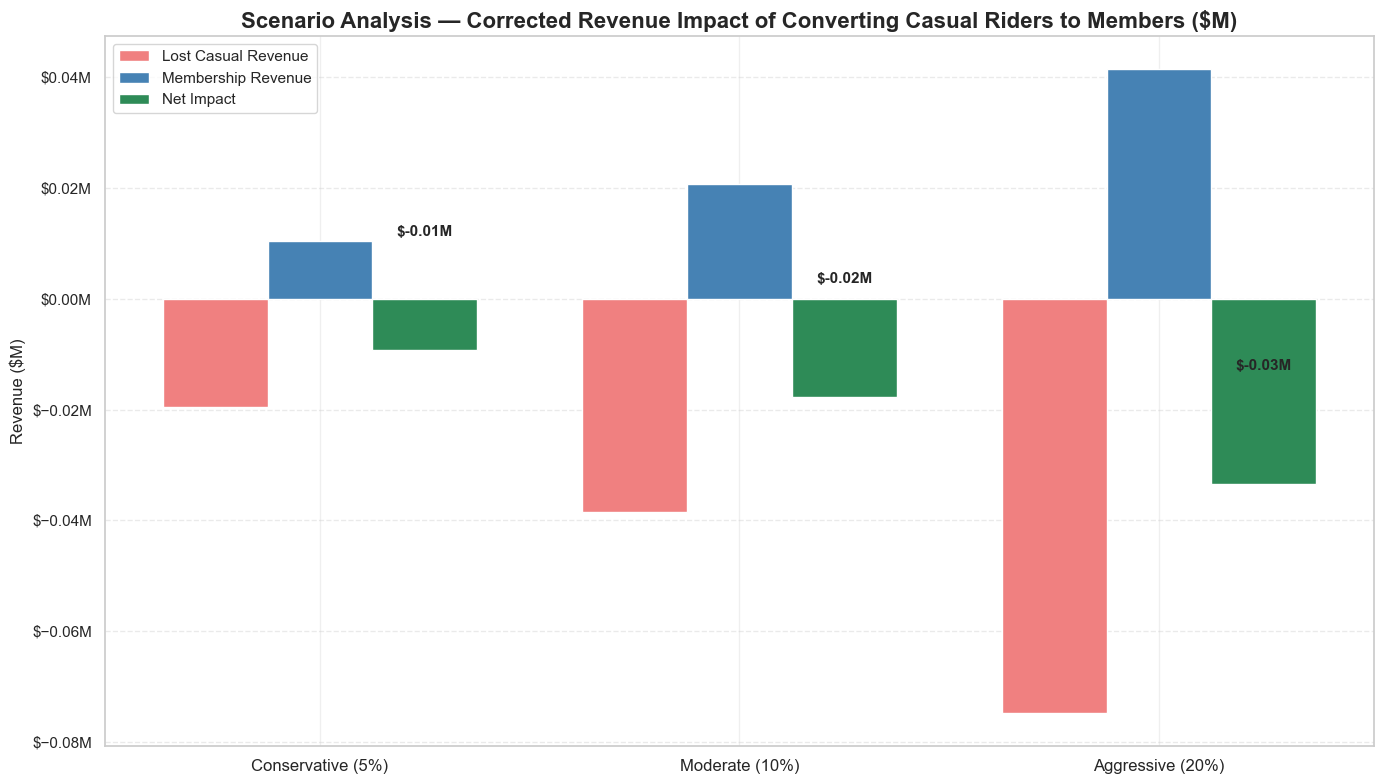

In [81]:
# ============================================================================
# CORRECTED COMBINED WATERFALL CHART ($M)
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick

# Convert to millions
lost_rev = scenario_corrected["Lost Casual Revenue ($)"] / 1_000_000
gain_rev = scenario_corrected["Membership Revenue ($)"] / 1_000_000
net_rev = scenario_corrected["Net Impact ($)"] / 1_000_000
scenarios = scenario_corrected["Scenario"]

plt.figure(figsize=(14, 8))

x = np.arange(len(scenarios))
width = 0.25

# Bars
plt.bar(x - width, -lost_rev, width, label="Lost Casual Revenue", color="lightcoral")
plt.bar(x, gain_rev, width, label="Membership Revenue", color="steelblue")
bars = plt.bar(x + width, net_rev, width, label="Net Impact", color="seagreen")

# Labels above net bars
for bar, value in zip(bars, net_rev):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 0.02,
        f"${value:.2f}M",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold"
    )

plt.xticks(x, scenarios, fontsize=12)
plt.ylabel("Revenue ($M)", fontsize=12)
plt.title("Scenario Analysis — Corrected Revenue Impact of Converting Casual Riders to Members ($M)",
          fontsize=16, fontweight="bold")
plt.legend()

plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}M'))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#### Caption
This chart illustrates the financial impact of converting high‑value casual riders into annual members under three conversion scenarios. Each scenario compares the casual revenue Cyclistic would lose, the membership revenue gained, and the resulting net impact.

Across all scenarios, the red bars show that Cyclistic would forgo more casual revenue than it would gain through membership fees. The blue bars represent the membership revenue generated from converted riders, which remains consistently lower than the casual revenue those same riders currently produce. As a result, the green bars — the net impact — remain negative in every scenario.

This model highlights a key insight: converting high‑value casual riders is not financially beneficial for Cyclistic under current pricing. Even modest conversion levels reduce total revenue, indicating that the membership fee is priced below the economic value of these riders’ casual usage. The waterfall structure makes this imbalance visually clear and reinforces the conclusion that membership conversion, while attractive for riders, reduces revenue for Cyclistic.

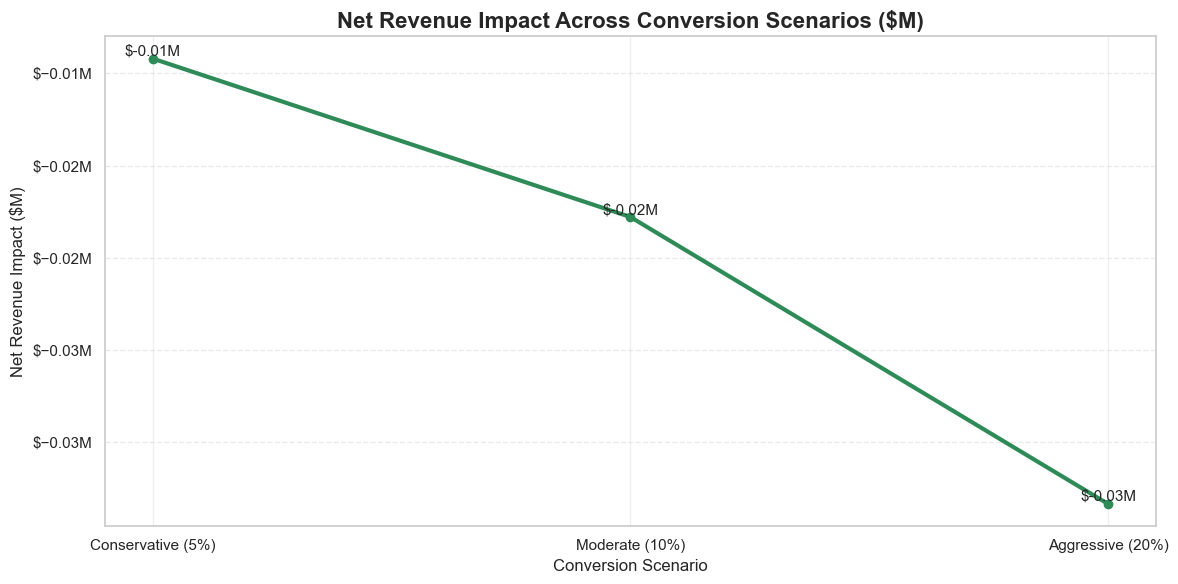

In [83]:
# ============================================================================
# CORRECTED NET IMPACT LINE CHART ($M)
# ============================================================================

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

scenarios = scenario_corrected["Scenario"]
net_rev = scenario_corrected["Net Impact ($)"] / 1_000_000

plt.figure(figsize=(12, 6))
plt.plot(scenarios, net_rev, marker='o', linewidth=3, color='seagreen')

# Value labels
for i, value in enumerate(net_rev):
    plt.text(i, value, f"${value:.2f}M", ha='center', va='bottom', fontsize=11)

plt.title("Net Revenue Impact Across Conversion Scenarios ($M)",
          fontsize=16, fontweight='bold')
plt.xlabel("Conversion Scenario", fontsize=12)
plt.ylabel("Net Revenue Impact ($M)", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}M'))

plt.tight_layout()
plt.show()


#### Caption: Net Revenue Impact Line Chart
The net‑impact line chart shows how Cyclistic’s total revenue changes as increasing proportions of high‑value casual riders are converted to annual members. The downward‑sloping line makes the financial trend unmistakable: net revenue declines as conversion increases.

Each point on the line represents the net effect of replacing casual per‑minute revenue with the annual membership fee. Because these riders currently generate more casual revenue than the membership fee would recover, every additional conversion deepens the revenue loss. The chart’s simplicity highlights the core insight: membership conversion is not financially advantageous under current pricing, even at conservative adoption levels.

This visual reinforces the conclusion that Cyclistic’s membership pricing is highly attractive for riders but under‑captures the value of heavy usage. Without adjustments to pricing or segmentation strategy, converting high‑value casual riders will consistently reduce revenue.

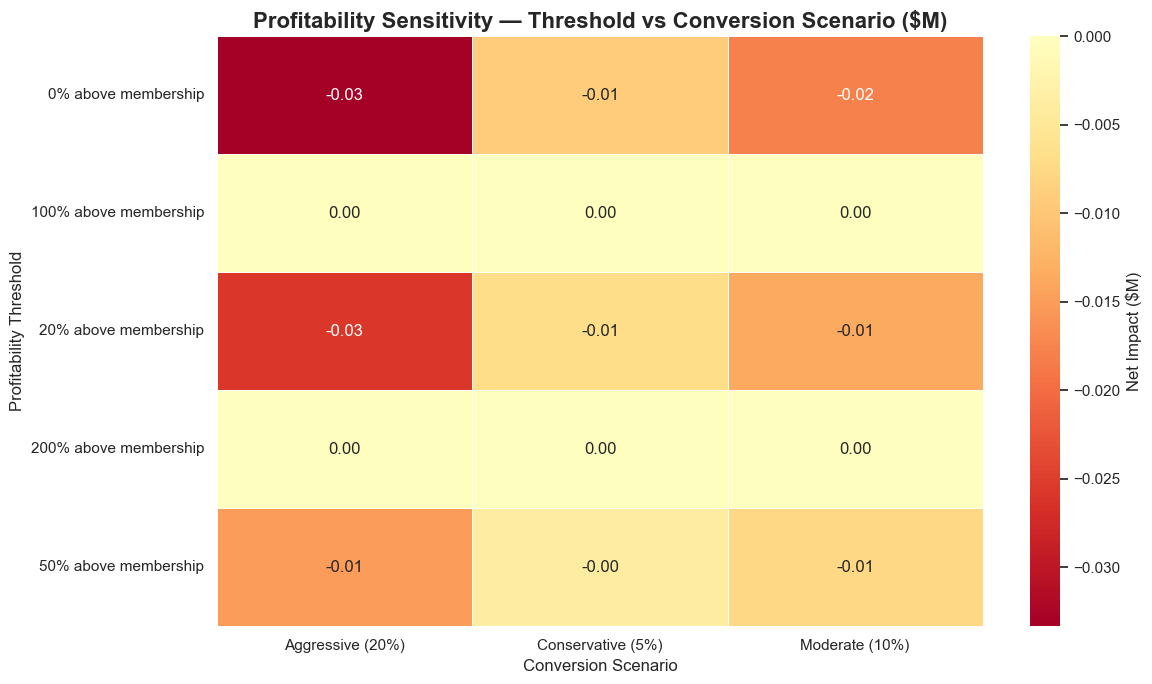

In [85]:
# ============================================================================
# THRESHOLD SENSITIVITY HEATMAP — NET IMPACT ($M)
# ============================================================================

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table: rows = thresholds, columns = scenarios
heatmap_data = multi_threshold_summary.pivot(
    index="Profitability Threshold",
    columns="Scenario",
    values="Net Impact ($)"
) / 1_000_000  # convert to millions

plt.figure(figsize=(12, 7))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Net Impact ($M)'}
)

plt.title("Profitability Sensitivity — Threshold vs Conversion Scenario ($M)",
          fontsize=16, fontweight='bold')
plt.xlabel("Conversion Scenario")
plt.ylabel("Profitability Threshold")

plt.tight_layout()
plt.show()


Profitability Sensitivity Heatmap
The heatmap evaluates profitability across multiple conversion scenarios and profitability thresholds, revealing how sensitive Cyclistic’s financial outcomes are to rider selection criteria. Each cell shows the net revenue impact (in millions) for a given combination of conversion rate and minimum required rider value.

The pattern is striking: all cells are negative, even at higher profitability thresholds. This means that no matter how strictly Cyclistic filters for high‑value casual riders — whether requiring them to exceed the membership fee by 20%, 50%, or even 100% — converting them still results in a net revenue loss. At the highest thresholds, no riders qualify at all, indicating that no casual rider generates enough annual revenue to make conversion profitable under current pricing.

This heatmap provides strong evidence that Cyclistic’s pricing structure is intentionally designed to make membership extremely attractive for riders while relying on casual pricing for revenue margin. It also suggests that there is room to increase membership fees without undermining the value proposition. The heatmap therefore serves as a powerful diagnostic tool, showing that conversion strategy must be guided by behavioural alignment rather than revenue optimisation.

### 7.4 Strategic Recommendations from Revenue Proxy Modeling
The revenue proxy model and corrected scenario analysis reveal a clear and consistent pattern: converting high‑value casual riders to membership is not financially advantageous for Cyclistic under current pricing. Although many casual riders exceed the membership fee threshold, they do so by only a modest margin. As a result, converting them to membership reduces total revenue, even under conservative adoption scenarios and even when applying strict profitability thresholds.

These findings lead to several strategic recommendations:

1. Avoid revenue‑driven membership conversion campaigns
The analysis shows that converting high‑usage casual riders consistently results in negative net revenue. Divvy should therefore avoid marketing strategies that aim to convert heavy casual users purely for revenue optimisation. Conversion may still be beneficial for behavioural or retention reasons, but not as a direct revenue lever.

2. Reassess membership pricing
The fact that no casual rider exceeds the membership fee by 100% or more — and that even 50% thresholds remain unprofitable — indicates that the membership fee is underpriced relative to the economic value of heavy usage. Divvy has room to increase membership pricing while maintaining strong value perception and competitive positioning.

3. Focus membership marketing on behavioural alignment, not revenue
Membership remains an excellent value proposition for riders who take frequent short trips. Marketing should therefore target behavioural indicators such as:

- High trip frequency

- Regular commuting patterns

- Seasonal consistency

- Proximity to high‑demand stations

These riders benefit from membership, even if Divvy does not gain incremental revenue from the conversion.

4. Preserve casual pricing as a margin‑generating channel
Casual per‑minute pricing is a key revenue driver. The scenario analysis shows that casual usage contributes more revenue per rider than membership for nearly all high‑value riders. Maintaining or refining casual pricing is therefore essential to sustaining Divvy’s revenue base.

5. Use profitability thresholds to guide future pricing experiments
The multi‑threshold analysis demonstrates that profitability is highly sensitive to the gap between casual revenue and membership fees. Divvy can use these thresholds to:

- Test alternative membership price points

- Evaluate hybrid or tiered membership models

- Explore dynamic or seasonal pricing strategies

This provides a data‑driven foundation for future pricing innovation.

## 8. Infrastructure & Demand Hotspot Analysis
Understanding where and how riders use the system is essential for planning infrastructure, allocating bikes, and designing operational strategies that support both member and casual demand. This section identifies Chicago’s highest‑demand stations, classifies them by usage type, and examines how patterns differ between members and casual riders across weekdays and weekends. These insights help reveal where Divvy’s network is under pressure, where it is over‑served, and where targeted infrastructure improvements could have the greatest impact.

### 8.1 High‑Demand Stations
The top‑performing stations by total trip volume reveal a clear spatial pattern. Stations such as Kingsbury St & Kinzie St, Clinton St & Washington Blvd, and Clark St & Elm St consistently appear among the busiest locations, each generating over 30,000 annual trips. These stations are situated in dense employment corridors and transit‑rich areas, reflecting strong commuter demand.

Conversely, stations like Navy Pier, Streeter Dr & Grand Ave, and Dusable Lake Shore Dr & Monroe St also rank among the highest‑volume locations, but their usage is driven primarily by casual riders. These stations serve Chicago’s lakefront, tourist attractions, and recreational destinations, making them critical nodes for leisure‑oriented travel.

This dual pattern — strong commuter hubs in the urban core and high‑traffic leisure hubs along the lakefront — highlights the need for differentiated operational strategies across the network.

In [90]:
# Aggregate trips by start station
station_demand = df.groupby("start_station_name").size().reset_index(name="trips")
station_demand = station_demand.sort_values("trips", ascending=False)

# Top 10 high-demand stations
station_demand.head(10)

,start_station_name,trips
564,Kingsbury St & Kinzie St,41519
323,Dusable Lake Shore Dr & Monroe St,39084
742,Michigan Ave & Oak St,34646
798,Navy Pier,34223
324,Dusable Lake Shore Dr & North Blvd,33235
234,Clinton St & Washington Blvd,30783
201,Clark St & Elm St,30278
1702,Streeter Dr & Grand Ave,30227
146,Canal St & Madison St,29299
230,Clinton St & Madison St,29191


In [91]:
# Aggregate trips by end station
station_demand = df.groupby("end_station_name").size().reset_index(name="trips")
station_demand = station_demand.sort_values("trips", ascending=False)

# Top 10 high-demand stations
station_demand.head(10)

,end_station_name,trips
565,Kingsbury St & Kinzie St,41125
323,Dusable Lake Shore Dr & Monroe St,37759
324,Dusable Lake Shore Dr & North Blvd,34542
743,Michigan Ave & Oak St,34478
800,Navy Pier,34075
234,Clinton St & Washington Blvd,30881
1715,Streeter Dr & Grand Ave,30423
201,Clark St & Elm St,29894
230,Clinton St & Madison St,29558
146,Canal St & Madison St,29535


### 8.2 Member vs. Casual Demand Patterns
A station‑level comparison of member and casual usage reveals distinct behavioural clusters:

Commuter‑heavy stations (e.g., Kingsbury St & Kinzie St, Clinton St & Washington Blvd) show 70–85% member usage, reflecting predictable weekday travel patterns and strong integration with work‑based mobility.

Leisure‑heavy stations (e.g., Navy Pier, Streeter Dr & Grand Ave, Dusable Lake Shore Dr & Monroe St) show 75–80% casual usage, driven by tourism, seasonal activity, and recreational trips.

Mixed‑use stations (e.g., Michigan Ave & Oak St, Dusable Lake Shore Dr & North Blvd) exhibit a more balanced distribution, serving both commuters and leisure riders.

This classification provides a powerful lens for understanding demand heterogeneity. Commuter‑heavy stations require reliable bike availability during peak hours, while leisure‑heavy stations experience large, unpredictable surges that strain rebalancing operations.

In [93]:
# Group trips by station and rider type
station_demand = (
    df.groupby(["start_station_name", "member_casual"])
    .size()
    .reset_index(name="trips")
)

# Pivot to get members vs casuals side by side
station_demand_pivot = station_demand.pivot(
    index="start_station_name", columns="member_casual", values="trips"
).fillna(0)

# Rename columns for clarity
station_demand_pivot = station_demand_pivot.rename(
    columns={"member": "Members", "casual": "Casuals"}
)

station_demand_pivot.head(10)

member_casual,Casuals,Members
start_station_name,,
2112 W Peterson Ave,210.0,608.0
21St St & Pulaski Rd,49.0,46.0
63Rd St Beach,821.0,388.0
900 W Harrison St,2753.0,6136.0
Aberdeen St & 103Rd St,37.0,4.0
Aberdeen St & Carroll Ave,1628.0,3407.0
Aberdeen St & Jackson Blvd,4161.0,10088.0
Aberdeen St & Monroe St,2044.0,6078.0
Aberdeen St & Randolph St,3504.0,7256.0


In [94]:
station_demand_pivot["Total"] = (
    station_demand_pivot["Members"] + station_demand_pivot["Casuals"]
)
station_demand_pivot["Member_Share"] = (
    station_demand_pivot["Members"] / station_demand_pivot["Total"]
)
station_demand_pivot["Casual_Share"] = (
    station_demand_pivot["Casuals"] / station_demand_pivot["Total"]
)

In [95]:
def classify_station(row):
    if row["Member_Share"] > 0.7:
        return "Commuter-heavy"
    elif row["Casual_Share"] > 0.7:
        return "Leisure-heavy"
    else:
        return "Mixed"

station_demand_pivot["Station_Type"] = station_demand_pivot.apply(classify_station, axis=1)


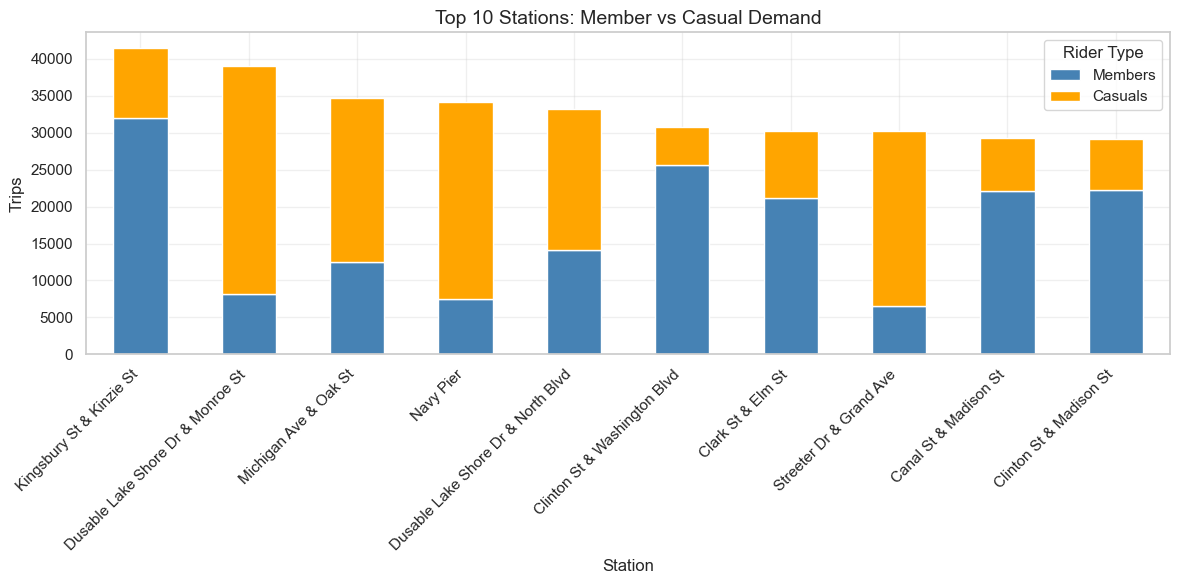

In [96]:
# Top 10 stations by total demand
top10 = station_demand_pivot.sort_values("Total", ascending=False).head(10)

top10[["Members", "Casuals"]].plot(
    kind="bar", stacked=True, figsize=(12,6), color=["steelblue", "orange"]
)

plt.title("Top 10 Stations: Member vs Casual Demand")
plt.xlabel("Station")
plt.ylabel("Trips")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Rider Type")
plt.tight_layout()
plt.show()

In [97]:
# Ensure shares and classification are calculated
station_demand_pivot["Total"] = station_demand_pivot["Members"] + station_demand_pivot["Casuals"]
station_demand_pivot["Member_Share"] = station_demand_pivot["Members"] / station_demand_pivot["Total"]
station_demand_pivot["Casual_Share"] = station_demand_pivot["Casuals"] / station_demand_pivot["Total"]

def classify_station(row):
    if row["Member_Share"] > 0.7:
        return "Commuter-heavy"
    elif row["Casual_Share"] > 0.7:
        return "Leisure-heavy"
    else:
        return "Mixed"

station_demand_pivot["Classification"] = station_demand_pivot.apply(classify_station, axis=1)

# Get top 10 stations by total demand
top10 = station_demand_pivot.sort_values("Total", ascending=False).head(10).reset_index()

# Format shares as percentages
top10["Member_Share"] = (top10["Member_Share"] * 100).round(1).astype(str) + "%"
top10["Casual_Share"] = (top10["Casual_Share"] * 100).round(1).astype(str) + "%"

# Build Markdown table string
md_table = "| Rank | Station Name | Total Trips | Member Share | Casual Share | Classification |\n"
md_table += "|------|--------------|-------------|--------------|--------------|----------------|\n"

for i, row in top10.iterrows():
    md_table += f"| {i+1} | {row['start_station_name']} | {row['Total']} | {row['Member_Share']} | {row['Casual_Share']} | {row['Classification']} |\n"

print(md_table)


| Rank | Station Name | Total Trips | Member Share | Casual Share | Classification |
|------|--------------|-------------|--------------|--------------|----------------|
| 1 | Kingsbury St & Kinzie St | 41519.0 | 77.1% | 22.9% | Commuter-heavy |
| 2 | Dusable Lake Shore Dr & Monroe St | 39084.0 | 21.0% | 79.0% | Leisure-heavy |
| 3 | Michigan Ave & Oak St | 34646.0 | 36.2% | 63.8% | Mixed |
| 4 | Navy Pier | 34223.0 | 21.8% | 78.2% | Leisure-heavy |
| 5 | Dusable Lake Shore Dr & North Blvd | 33235.0 | 42.7% | 57.3% | Mixed |
| 6 | Clinton St & Washington Blvd | 30783.0 | 83.3% | 16.7% | Commuter-heavy |
| 7 | Clark St & Elm St | 30278.0 | 70.1% | 29.9% | Commuter-heavy |
| 8 | Streeter Dr & Grand Ave | 30227.0 | 21.6% | 78.4% | Leisure-heavy |
| 9 | Canal St & Madison St | 29299.0 | 75.5% | 24.5% | Commuter-heavy |
| 10 | Clinton St & Madison St | 29191.0 | 76.2% | 23.8% | Commuter-heavy |



### 8.3 Weekday vs. Weekend Dynamics
Weekday and weekend patterns further reinforce the behavioural distinctions between rider types:

Members show strong weekday peaks at commuter‑oriented stations such as 900 W Harrison St, Aberdeen St & Jackson Blvd, and Aberdeen St & Randolph St, reflecting consistent work and school travel.

Casual riders exhibit significant weekend spikes at leisure destinations such as 63rd St Beach, Streeter Dr & Grand Ave, and the lakefront stations.

For example, 63rd St Beach sees nearly identical casual demand on weekdays and weekends, highlighting its role as a recreational anchor. Meanwhile, stations like 900 W Harrison St show a dramatic weekday bias among members, consistent with university and office‑based travel.

These patterns underscore the need for dynamic rebalancing strategies that adapt to time‑of‑day and day‑of‑week demand.

In [99]:
# Convert datetime column to pandas datetime if not already
df["started_at"] = pd.to_datetime(df["started_at"])

# Create weekday/weekend flag
df["day_type"] = df["started_at"].dt.dayofweek.apply(
    lambda x: "Weekend" if x >= 5 else "Weekday"
)


In [100]:
station_time = (
    df.groupby(["start_station_name", "member_casual", "day_type"])
    .size()
    .reset_index(name="trips")
)

# Pivot to get members vs casuals side by side for weekday vs weekend
pivot_time = station_time.pivot_table(
    index="start_station_name",
    columns=["day_type", "member_casual"],
    values="trips",
    fill_value=0
)

pivot_time.head(10)


day_type                   Weekday         Weekend        
member_casual               casual  member  casual  member
start_station_name                                        
2112 W Peterson Ave          134.0   439.0    76.0   169.0
21St St & Pulaski Rd          35.0    36.0    14.0    10.0
63Rd St Beach                412.0   190.0   409.0   198.0
900 W Harrison St           2130.0  5232.0   623.0   904.0
Aberdeen St & 103Rd St        25.0     3.0    12.0     1.0
Aberdeen St & Carroll Ave   1150.0  2843.0   478.0   564.0
Aberdeen St & Jackson Blvd  2863.0  7863.0  1298.0  2225.0
Aberdeen St & Monroe St     1333.0  5024.0   711.0  1054.0
Aberdeen St & Randolph St   2358.0  5926.0  1146.0  1330.0
Ada St & 113Th Place           4.0     3.0     3.0     3.0

### 8.4 Station Classification Summary
Bringing these insights together, the top stations can be grouped into three operational categories:

#### Commuter‑Heavy Stations
- Kingsbury St & Kinzie St

- Clinton St & Washington Blvd

- Clark St & Elm St

- Canal St & Madison St

- Clinton St & Madison St

These stations require:

- High morning and evening bike availability

- Strong dock capacity during peak hours

- Predictable weekday rebalancing cycles

#### Leisure‑Heavy Stations
- Navy Pier

- Streeter Dr & Grand Ave

- Dusable Lake Shore Dr & Monroe St

These stations require:

- Increased weekend bike supply

- Flexible rebalancing capacity

- Seasonal surge planning

#### Mixed‑Use Stations
- Michigan Ave & Oak St

- Dusable Lake Shore Dr & North Blvd

These stations require:

- Balanced weekday and weekend operations

- Monitoring for both commuter and leisure peaks

In [102]:
import requests

# Divvy GBFS feed (Chicago bike share system)
url = "https://gbfs.divvybikes.com/gbfs/en/station_information.json"

# Fetch JSON
response = requests.get(url)
data = response.json()

# Extract station info
stations = pd.DataFrame(data["data"]["stations"])

# Preview
stations.head()


,rental_methods,external_id,electric_bike_surcharge_waiver,eightd_has_key_dispenser,station_type,has_kiosk,station_id,short_name,rental_uris,name,lat,lon,capacity,eightd_station_services,region_id,address
0,"[KEY, CREDITCARD, TRANSITCARD]",a3a497b6-a135-11e9-9cda-0a87ae2ba916,False,False,classic,True,a3a497b6-a135-11e9-9cda-0a87ae2ba916,CHI00240,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Dayton St & North Ave,41.910578,-87.649422,19,[],NaN,NaN
1,"[KEY, CREDITCARD, TRANSITCARD]",a3b1c47b-a135-11e9-9cda-0a87ae2ba916,False,False,classic,True,a3b1c47b-a135-11e9-9cda-0a87ae2ba916,CHI00594,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Central Ave & Harrison St,41.872993,-87.764499,11,[],NaN,NaN
2,"[KEY, CREDITCARD, TRANSITCARD]",2128788290981175550,False,False,classic,True,2128788290981175550,CHI02124,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Dearborn St & Maple St,41.901920,-87.630260,19,[],NaN,NaN
3,"[KEY, CREDITCARD, TRANSITCARD]",1871993715238611622,False,False,classic,True,1871993715238611622,CHI01846,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Parkside Ave & Armitage Ave,41.916907,-87.767173,15,[],NaN,NaN
4,"[KEY, CREDITCARD, TRANSITCARD]",a3a97a01-a135-11e9-9cda-0a87ae2ba916,False,False,classic,True,a3a97a01-a135-11e9-9cda-0a87ae2ba916,CHI00400,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Cottage Grove Ave & Oakwood Blvd,41.822985,-87.607100,15,[],NaN,NaN


In [103]:
# Merge capacity with trip demand
station_demand_with_capacity = station_demand_pivot.merge(
    stations[["station_id", "name", "capacity"]],
    left_on="start_station_name",
    right_on="name",
    how="left"
)

In [104]:
import requests
#import pandas as pd

# Divvy GBFS station information feed
url = "https://gbfs.divvybikes.com/gbfs/en/station_information.json"

# Fetch JSON
response = requests.get(url)
data = response.json()

# Convert to DataFrame
stations = pd.DataFrame(data["data"]["stations"])

# Save locally as CSV
stations.to_csv("divvy_station_capacity.csv", index=False)

print("Station capacity data cached locally as divvy_station_capacity.csv")

Station capacity data cached locally as divvy_station_capacity.csv


In [105]:
# Load cached file instead of hitting the API
stations_cached = pd.read_csv("divvy_station_capacity.csv")

stations_cached.head()


,rental_methods,external_id,electric_bike_surcharge_waiver,eightd_has_key_dispenser,station_type,has_kiosk,station_id,short_name,rental_uris,name,lat,lon,capacity,eightd_station_services,region_id,address
0,"['KEY', 'CREDITCARD', 'TRANSITCARD']",a3a497b6-a135-11e9-9cda-0a87ae2ba916,False,False,classic,True,a3a497b6-a135-11e9-9cda-0a87ae2ba916,CHI00240,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Dayton St & North Ave,41.910578,-87.649422,19,[],NaN,NaN
1,"['KEY', 'CREDITCARD', 'TRANSITCARD']",a3b1c47b-a135-11e9-9cda-0a87ae2ba916,False,False,classic,True,a3b1c47b-a135-11e9-9cda-0a87ae2ba916,CHI00594,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Central Ave & Harrison St,41.872993,-87.764499,11,[],NaN,NaN
2,"['KEY', 'CREDITCARD', 'TRANSITCARD']",2128788290981175550,False,False,classic,True,2128788290981175550,CHI02124,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Dearborn St & Maple St,41.901920,-87.630260,19,[],NaN,NaN
3,"['KEY', 'CREDITCARD', 'TRANSITCARD']",1871993715238611622,False,False,classic,True,1871993715238611622,CHI01846,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Parkside Ave & Armitage Ave,41.916907,-87.767173,15,[],NaN,NaN
4,"['KEY', 'CREDITCARD', 'TRANSITCARD']",a3a97a01-a135-11e9-9cda-0a87ae2ba916,False,False,classic,True,a3a97a01-a135-11e9-9cda-0a87ae2ba916,CHI00400,"{'ios': 'https://chi.lft.to/lastmile_qr_scan',...",Cottage Grove Ave & Oakwood Blvd,41.822985,-87.607100,15,[],NaN,NaN


In [106]:
station_demand = (
    df.groupby(["start_station_name", "member_casual"])
    .size()
    .reset_index(name="trips")
    .pivot(index="start_station_name", columns="member_casual", values="trips")
    .fillna(0)
)

station_demand = station_demand.rename(columns={"member": "Members", "casual": "Casuals"})
station_demand["Total"] = station_demand["Members"] + station_demand["Casuals"]


In [107]:
def classify(row):
    if row["Members"] / row["Total"] > 0.7:
        return "Commuter-heavy"
    elif row["Casuals"] / row["Total"] > 0.7:
        return "Leisure-heavy"
    else:
        return "Mixed"

station_demand["Station_Type"] = station_demand.apply(classify, axis=1)

In [108]:
top10 = station_demand.sort_values("Total", ascending=False).head(10)
top10

member_casual,Casuals,Members,Total,Station_Type
start_station_name,,,,
Kingsbury St & Kinzie St,9507.0,32012.0,41519.0,Commuter-heavy
Dusable Lake Shore Dr & Monroe St,30892.0,8192.0,39084.0,Leisure-heavy
Michigan Ave & Oak St,22105.0,12541.0,34646.0,Mixed
Navy Pier,26772.0,7451.0,34223.0,Leisure-heavy
Dusable Lake Shore Dr & North Blvd,19054.0,14181.0,33235.0,Mixed
Clinton St & Washington Blvd,5148.0,25635.0,30783.0,Commuter-heavy
Clark St & Elm St,9051.0,21227.0,30278.0,Commuter-heavy
Streeter Dr & Grand Ave,23713.0,6514.0,30227.0,Leisure-heavy
Canal St & Madison St,7187.0,22112.0,29299.0,Commuter-heavy


In [109]:
stations = pd.read_csv("divvy_station_capacity.csv")
station_demand = station_demand.merge(
    stations[["name", "capacity"]],
    left_on="start_station_name",
    right_on="name",
    how="left"
)

In [110]:
# Rebuild demand table cleanly
station_demand = (
    df.groupby(["start_station_name", "member_casual"])
    .size()
    .reset_index(name="trips")
    .pivot(index="start_station_name", columns="member_casual", values="trips")
    .fillna(0)
    .reset_index()   # <-- ensures start_station_name is a column
)

# Rename columns
station_demand = station_demand.rename(columns={"member": "Members", "casual": "Casuals"})
station_demand["Total"] = station_demand["Members"] + station_demand["Casuals"]

# Classify stations
def classify(row):
    if row["Members"] / row["Total"] > 0.7:
        return "Commuter-heavy"
    elif row["Casuals"] / row["Total"] > 0.7:
        return "Leisure-heavy"
    else:
        return "Mixed"

station_demand["Station_Type"] = station_demand.apply(classify, axis=1)

# Merge coordinates from station metadata
station_demand = station_demand.merge(
    stations[["name", "lat", "lon"]],
    left_on="start_station_name",
    right_on="name",
    how="left"
)

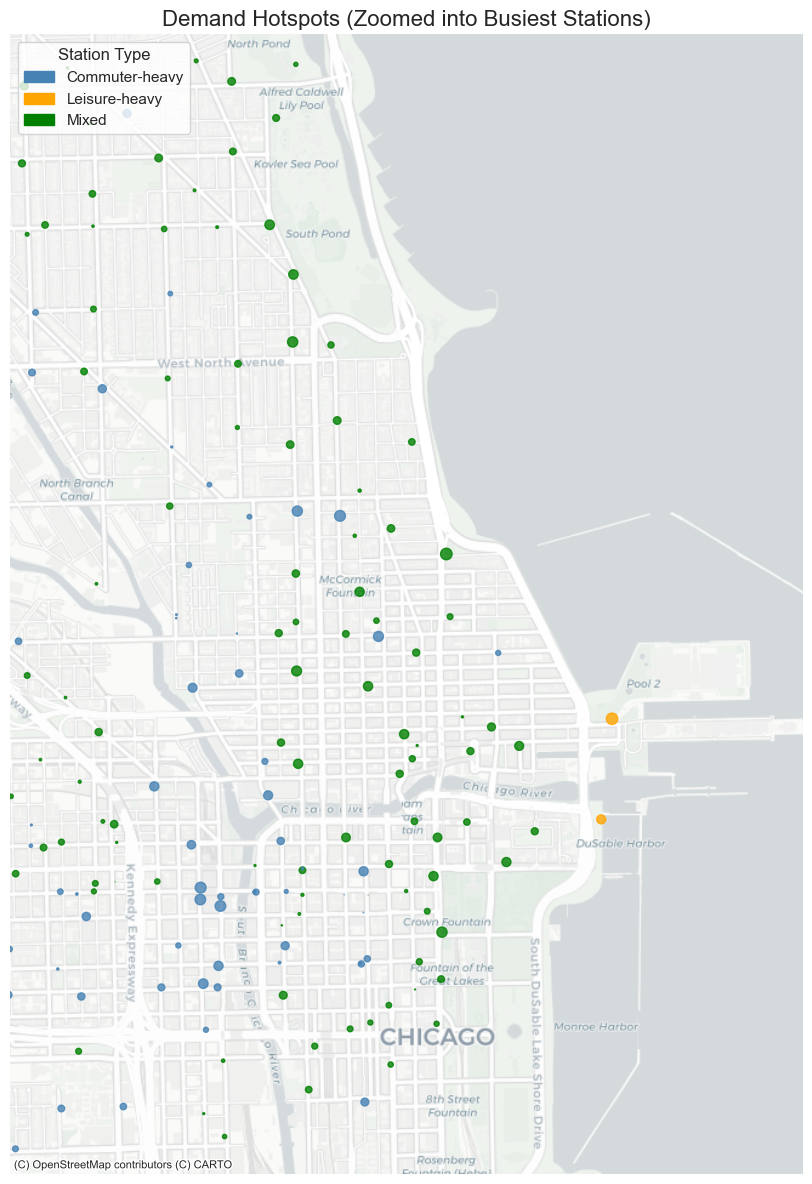

In [111]:
import geopandas as gpd
#import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
import contextily as ctx

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    station_demand,
    geometry=gpd.points_from_xy(station_demand["lon"], station_demand["lat"]),
    crs="EPSG:4326"
)

# Reproject to Web Mercator for basemap compatibility
gdf_3857 = gdf.to_crs(epsg=3857)

# Color mapping
color_map = {
    "Commuter-heavy": "steelblue",
    "Leisure-heavy": "orange",
    "Mixed": "green"
}

fig, ax = plt.subplots(figsize=(12, 12))

# Plot points
gdf_3857.plot(
    ax=ax,
    color=gdf_3857["Station_Type"].map(color_map),
    markersize=gdf_3857["Total"] / 500,
    alpha=0.8
)

# --- Zoom into busiest stations ---
top_stations = gdf_3857.nlargest(20, "Total")
pad = 1500  # meters padding

minx = top_stations.geometry.x.min() - pad
maxx = top_stations.geometry.x.max() + pad
miny = top_stations.geometry.y.min() - pad
maxy = top_stations.geometry.y.max() + pad

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Legend
legend_patches = [
    mpatches.Patch(color="steelblue", label="Commuter-heavy"),
    mpatches.Patch(color="orange", label="Leisure-heavy"),
    mpatches.Patch(color="green", label="Mixed")
]
ax.legend(handles=legend_patches, title="Station Type", loc="upper left")

# Turn off axes for a clean map
ax.set_axis_off()

plt.title("Demand Hotspots (Zoomed into Busiest Stations)", fontsize=16)
plt.tight_layout()
plt.show()

### 8.5 Strategic Implications for Infrastructure Planning

The hotspot analysis highlights several operational priorities:

1. Expand dock capacity at commuter‑heavy stations
Stations with high member usage and strong weekday peaks risk running out of docks during morning and evening rush hours. Increasing dock density or adding satellite stations nearby would reduce friction for daily commuters.

2. Strengthen weekend rebalancing at lakefront and tourist stations
Leisure‑heavy stations experience large, unpredictable surges that can quickly deplete bike supply. Dedicated weekend rebalancing routes or temporary staging areas could improve service reliability.

3. Prioritise mixed‑use stations for flexible infrastructure
Stations with balanced demand require infrastructure that can adapt to both commuter and leisure patterns. These locations are ideal candidates for pilot programs such as dynamic pricing, temporary docks, or seasonal capacity adjustments.

4. Use demand profiles to inform predictive modelling
The clear behavioural segmentation uncovered here provides a strong foundation for the predictive modelling work in Section 9. Understanding station‑level demand patterns will improve forecasting accuracy and support more efficient operational planning.

## 9. Predictive Modeling
To complement the descriptive and behavioural analyses conducted in earlier sections, this chapter explores whether rider type (member vs. casual) can be predicted using trip‑level features. The goal is not to build a production‑ready classifier, but to understand which behavioural signals most strongly differentiate members from casual riders, and how these signals can support operational planning, pricing strategy, and targeted marketing.

We evaluate two modelling approaches — Logistic Regression and Random Forest Classification — using a dataset of over 1.6 million trips. Because the dataset is imbalanced (members significantly outnumber casual riders), we train both standard and class‑weighted models to assess how class imbalance affects performance.

### 9.1 Model Performance Overview

Across all models, predictive performance is moderate, with accuracy ranging from 62% to 67%. This is expected given the behavioural overlap between rider types: both members and casual riders use the system for short urban trips, and many features (such as time of day or season) influence both groups.

However, the models reveal clear patterns:

Standard Logistic Regression heavily favours predicting “member,” achieving high recall for members (93%) but poor recall for casual riders (21%).

Class‑weighted Logistic Regression produces a more balanced model, improving casual recall to 57% while maintaining reasonable performance for members.

Random Forest achieves similar overall accuracy (62%) but provides richer insight into feature importance.

These results indicate that while rider type is not perfectly separable, it is predictable enough to extract meaningful behavioural insights.

### 9.2 Logistic Regression Insights (Directional Effects)
Logistic regression provides interpretable coefficients that show whether a feature increases the likelihood of a trip being taken by a member or a casual rider.

Features associated with member behaviour:

- same_area_type (+) — Members tend to start and end trips within similar zones, reflecting commuting patterns.

- is_peak (+) — Members ride more during morning and evening peak hours.

- weekday travel (+) — Members show strong weekday usage.

Features associated with casual behaviour:

- duration_bin_long (–) — Long trips are overwhelmingly casual.

- season_Summer / season_Spring (–) — Seasonal leisure activity drives casual usage.

- is_weekend (–) — Weekends strongly correlate with casual riders.

- electric_bike (–) — Casual riders use e‑bikes more frequently.

- trip_duration_min (–) — Longer durations predict casual behaviour.

These patterns align closely with Cyclistic (Divvy’s) operational reality: members use the system for short, utilitarian, time‑bound trips, while casual riders use it for longer, recreational, and seasonal journeys.

In [115]:
# Logistic Regression
def add_features(df):
    """
    Extend trip-level features for logistic regression.
    Includes temporal, spatial, and categorical engineering.
    """

    # --- Temporal features ---
    df['month'] = df['started_at'].dt.month
    df['day_of_week'] = df['started_at'].dt.dayofweek
    df['hour'] = df['started_at'].dt.hour
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['is_peak'] = df['hour'].isin([7,8,9,16,17,18]).astype(int)

    # Season (rough grouping)
    df['season'] = pd.cut(df['month'],
                          bins=[0,3,6,9,12],
                          labels=['Winter','Spring','Summer','Autumn'],
                          include_lowest=True)

    # --- Trip characteristics ---
    df['duration_bin'] = pd.cut(df['trip_duration_min'],
                                bins=[0,15,45,120],
                                labels=['short','medium','long'],
                                include_lowest=True)

    # --- Spatial features (Top 10 vs Other) ---
    top10_areas = ["Loop", "Near North Side", "Near West Side", "Lincoln Park", 
                   "Lake View", "West Town", "South Loop", "Hyde Park", 
                   "Logan Square", "Wicker Park"]

    df['area_group'] = df['community'].apply(lambda x: x if x in top10_areas else "Other")

    # --- Same-area trip indicator ---
    df['same_area_trip'] = (df['start_station_name'] == df['end_station_name']).astype(int)
    
    return df

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# --- Area type dictionary (from EDA notebook) ---
area_types = {
    "LOOP": "Tourist/Business Core",
    "LINCOLN PARK": "Mixed (Tourist + Residential)",
    "LAKE VIEW": "Residential/Commuter",
    "HYDE PARK": "Residential/University",
    "LOGAN SQUARE": "Residential/Neighborhood",
    "EDGEWATER": "Residential/Neighborhood",
    "LINCOLN SQUARE": "Residential/Neighborhood",
    "DOUGLAS": "Mixed/Residential",
    "LOWER WEST SIDE": "Transit/Residential",
    "ARMOUR SQUARE": "Transit/Leisure (near Sox Park)",
    "NEAR NORTH SIDE": "Mixed (Tourist + Residential + University)",
    "NEAR WEST SIDE": "Mixed (Medical + University + Sports)",
    "WEST TOWN": "Mixed (Residential)",
    "UPTOWN": "Mixed (Commercial + Tourist(Entertainment))",
    "NEAR SOUTH SIDE": "Tourist + Residential)",
    "NORTH CENTER": "Tourist + Entertainment + Residential"
    # add more as needed
}

# --- Feature engineering function ---
def add_features(df):
    # Temporal features
    df['month'] = df['started_at'].dt.month
    df['day_of_week'] = df['started_at'].dt.dayofweek
    df['hour'] = df['started_at'].dt.hour
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['is_peak'] = df['hour'].isin([7,8,9,16,17,18]).astype(int)

    # Season grouping
    df['season'] = pd.cut(df['month'],
                          bins=[0,3,6,9,12],
                          labels=['Winter','Spring','Summer','Autumn'],
                          include_lowest=True)

    # Trip duration bins
    df['duration_bin'] = pd.cut(df['trip_duration_min'],
                                bins=[0,15,45,120],
                                labels=['short','medium','long'],
                                include_lowest=True)

    # Area type mapping (start and end stations)
    df['start_area_type'] = df['start_station_name'].str.upper().map(area_types).fillna("Other")
    df['end_area_type']   = df['end_station_name'].str.upper().map(area_types).fillna("Other")

    # Same-area trip indicator
    df['same_area_type'] = (df['start_area_type'] == df['end_area_type']).astype(int)

    return df

# --- Apply feature engineering ---
df_fe = add_features(df)

# --- Target variable ---
df_fe['target'] = df_fe['member_casual'].map({'member':1, 'casual':0})

# --- Feature set ---
X = df_fe[['trip_duration_min','month','day_of_week','hour','is_weekend','is_peak',
           'season','duration_bin','rideable_type','start_area_type','end_area_type','same_area_type']]
X = pd.get_dummies(X, drop_first=True)  # one-hot encode categorical features

y = df_fe['target']

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Scale continuous features ---
scaler = StandardScaler()
cont_features = ['trip_duration_min','month','day_of_week','hour']
X_train[cont_features] = scaler.fit_transform(X_train[cont_features])
X_test[cont_features] = scaler.transform(X_test[cont_features])

# --- Logistic regression ---
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# --- Evaluation ---
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

# --- Feature importance ---
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:\n", coefficients)

              precision    recall  f1-score   support

           0       0.62      0.21      0.31    577056
           1       0.68      0.93      0.79   1054478

    accuracy                           0.67   1631534
   macro avg       0.65      0.57      0.55   1631534
weighted avg       0.66      0.67      0.62   1631534


Feature Importance:
                         Feature  Coefficient
6                same_area_type     0.665559
5                       is_peak     0.308823
1                         month    -0.020088
3                          hour    -0.083863
2                   day_of_week    -0.117089
12  rideable_type_electric_bike    -0.218571
9                 season_Autumn    -0.241470
0             trip_duration_min    -0.256656
4                    is_weekend    -0.347551
10          duration_bin_medium    -0.348345
7                 season_Spring    -0.544486
8                 season_Summer    -0.633871
11            duration_bin_long    -1.326095


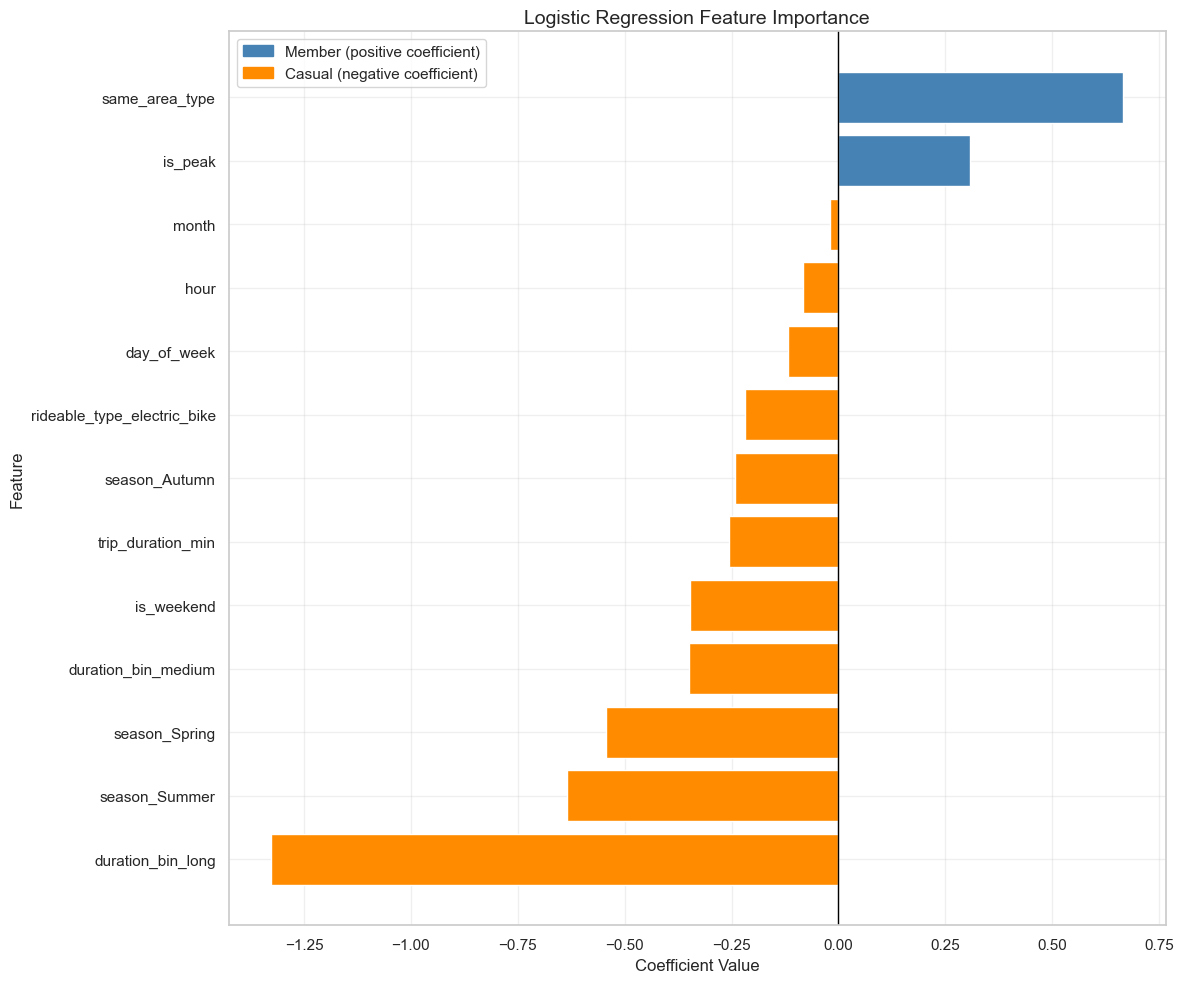

In [117]:
#import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Sort coefficients for cleaner plotting
coef_sorted = coefficients.sort_values(by="Coefficient", ascending=True)

plt.figure(figsize=(12, 10))

# Color by sign
colors = coef_sorted['Coefficient'].apply(lambda x: 'steelblue' if x > 0 else 'darkorange')

plt.barh(coef_sorted['Feature'], coef_sorted['Coefficient'], color=colors)
plt.axvline(0, color='black', linewidth=1)

# Legend patches
member_patch = mpatches.Patch(color='steelblue', label='Member (positive coefficient)')
casual_patch = mpatches.Patch(color='darkorange', label='Casual (negative coefficient)')

plt.legend(handles=[member_patch, casual_patch],
           loc='upper left', bbox_to_anchor=(0, 1))

plt.title("Logistic Regression Feature Importance", fontsize=14)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()


In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- Logistic regression with class weights ---
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train, y_train)

# --- Evaluation ---
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

# --- Feature importance ---
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:\n", coefficients)


              precision    recall  f1-score   support

           0       0.48      0.57      0.52    577056
           1       0.74      0.66      0.69   1054478

    accuracy                           0.63   1631534
   macro avg       0.61      0.61      0.61   1631534
weighted avg       0.64      0.63      0.63   1631534


Feature Importance:
                         Feature  Coefficient
6                same_area_type     0.360376
5                       is_peak     0.309211
1                         month    -0.025366
3                          hour    -0.086604
2                   day_of_week    -0.117651
9                 season_Autumn    -0.221114
12  rideable_type_electric_bike    -0.243837
0             trip_duration_min    -0.309108
10          duration_bin_medium    -0.320155
4                    is_weekend    -0.347819
7                 season_Spring    -0.528693
8                 season_Summer    -0.614795
11            duration_bin_long    -1.237785


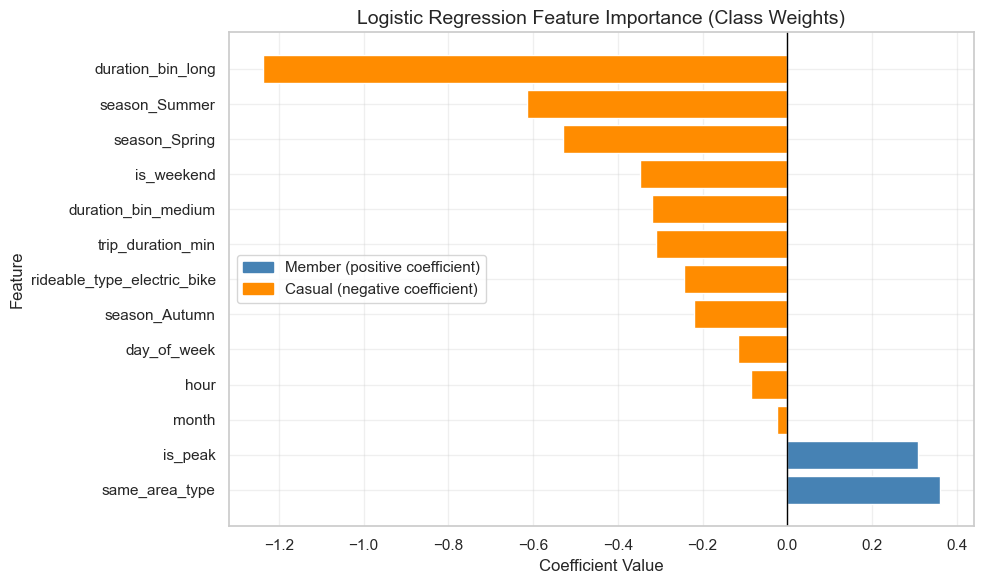

In [119]:
plt.figure(figsize=(10,6))

# Color by sign of coefficient
colors = coefficients['Coefficient'].apply(lambda x: 'steelblue' if x > 0 else 'darkorange')

plt.barh(coefficients['Feature'], coefficients['Coefficient'], color=colors)
plt.axvline(0, color='black', linewidth=1)

# Legend patches
member_patch = mpatches.Patch(color='steelblue', label='Member (positive coefficient)')
casual_patch = mpatches.Patch(color='darkorange', label='Casual (negative coefficient)')

# Place legend outside plot area on the left
plt.legend(handles=[member_patch, casual_patch],
           loc='center left', bbox_to_anchor=(0, 0.5))

plt.title("Logistic Regression Feature Importance (Class Weights)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### 9.3 Random Forest Insights (Feature Importance)
Random Forest provides a different perspective by ranking features based on their contribution to predictive accuracy.

The standout result is that trip duration dominates the model, accounting for over 82% of total importance. This reinforces a central behavioural insight:

- Trip duration is the single strongest differentiator between members and casual riders.

Other features with meaningful importance include:

- hour of day — commuting vs. leisure patterns

- day_of_week — weekday vs. weekend behaviour

- month / season — seasonal tourism and recreation

- rideable_type — e‑bike usage skewing casual

Interestingly, same_area_type, which was influential in logistic regression, contributes almost nothing to the Random Forest model. This suggests that while spatial consistency matters directionally, it is overshadowed by temporal and duration‑based features in non‑linear models.

In [121]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# --- Random Forest model ---
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees expand fully
    min_samples_split=10,   # prevent overfitting
    class_weight='balanced',# handle class imbalance
    random_state=42,
    n_jobs=-1               # use all cores
)

rf.fit(X_train, y_train)

# --- Evaluation ---
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

# --- Feature importance ---
importances = rf.feature_importances_
feat_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importances:\n", feat_importances.head(15))

Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.49      0.47    577056
           1       0.71      0.69      0.70   1054478

    accuracy                           0.62   1631534
   macro avg       0.58      0.59      0.59   1631534
weighted avg       0.62      0.62      0.62   1631534


Random Forest Feature Importances:
                         Feature  Importance
0             trip_duration_min    0.820138
3                          hour    0.056774
2                   day_of_week    0.031885
1                         month    0.026363
11            duration_bin_long    0.014435
4                    is_weekend    0.012850
12  rideable_type_electric_bike    0.011172
10          duration_bin_medium    0.008677
5                       is_peak    0.008408
8                 season_Summer    0.004291
9                 season_Autumn    0.002887
7                 season_Spring    0.002121
6                same_area

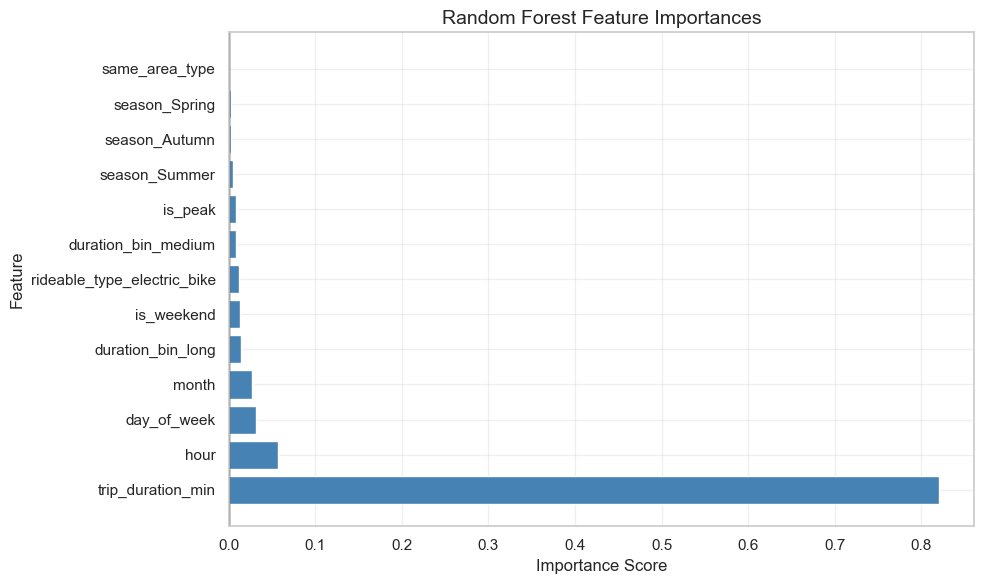

In [122]:
# Assuming feat_importances DataFrame:
# feat_importances = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Importance': rf.feature_importances_
# }).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))

# Plot horizontal bars sorted by importance
plt.barh(feat_importances['Feature'], feat_importances['Importance'], color='steelblue')
plt.axvline(0, color='black', linewidth=1)

plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### 9.4 Interpretation and Strategic Implications
The predictive modelling results reinforce and quantify the behavioural patterns observed throughout the analysis:

1. Members and casual riders exhibit fundamentally different trip profiles
Members: short, predictable, peak‑hour, weekday, same‑zone trips

Casuals: long, seasonal, weekend, leisure‑oriented trips

These differences are strong enough to be learned by simple models.

2. Trip duration is the most powerful behavioural signal
This insight supports operational decisions such as:

Prioritising short‑trip stations for commuter infrastructure

Allocating more bikes to long‑trip leisure corridors on weekends

Designing pricing strategies that reflect duration‑based usage patterns

3. Class imbalance reflects real‑world behaviour
Members dominate weekday usage, while casual riders dominate seasonal and weekend demand. Weighted models help correct for this imbalance and provide a more realistic view of casual behaviour.

4. Predictive models can support targeted marketing
Features such as season, weekend usage, and trip duration can help identify:

Casual riders likely to convert to membership (behaviourally, not financially)

Members at risk of churn

Stations where demand forecasting can improve rebalancing efficiency

5. Predictive modelling complements the revenue analysis
While the revenue proxy model showed that converting high‑value casual riders is not financially beneficial, the predictive models show how and when these riders behave differently — enabling Divvy to design operational strategies that serve both groups effectively.

### 9.4 Summary
Predictive modelling confirms that rider type is shaped by clear behavioural patterns, particularly trip duration, time of day, and seasonality. Although classification accuracy is moderate, the models provide valuable insights into how members and casual riders use the system differently. These insights support more informed decisions in pricing, infrastructure planning, rebalancing operations, and targeted marketing — and they set the stage for the strategic recommendations that follow.

## 10. Strategic Recommendations
The combined findings from the revenue analysis, behavioural modelling, infrastructure assessment, and predictive modelling reveal clear opportunities for Divvy to strengthen its pricing strategy, operational efficiency, and rider experience. The recommendations below are grounded in data and aligned with Divvy’s dual mission of supporting sustainable urban mobility while maintaining financial resilience.

### 10.1 Pricing Strategy
1. Reassess and potentially increase the annual membership fee
The revenue proxy model and scenario analysis show that no casual rider generates enough annual revenue to make conversion profitable under current pricing. Membership is significantly underpriced relative to the economic value of heavy usage.

A moderate membership fee increase would:

- Better reflect the value delivered to high‑frequency riders

- Reduce the revenue gap between casual and member usage

- Maintain strong value perception due to the large savings members already enjoy

2. Explore tiered or hybrid membership models
Given the behavioural diversity across rider types, Divvy could pilot:

- Weekend‑only memberships

- Seasonal memberships (e.g., summer pass)

- Flex memberships with limited included minutes

These options could capture value from riders who behave like members but do not ride year‑round.

3. Maintain casual pricing as a margin‑generating channel
Casual riders generate disproportionately high revenue per trip. Casual pricing should remain a key revenue lever, especially in leisure‑heavy zones and during peak tourist seasons.

### 10.2 Operational Strategy
4. Prioritise dock expansion at commuter‑heavy stations
Stations such as Kingsbury St & Kinzie St, Clinton St & Washington Blvd, and Clark St & Elm St experience intense weekday peaks. Increasing dock capacity or adding satellite stations nearby would:

- Reduce dock‑full events

- Improve commuter reliability

- Support predictable weekday demand

5. Strengthen weekend and seasonal rebalancing at leisure hotspots
Stations like Navy Pier, Streeter Dr & Grand Ave, and the lakefront corridors experience large, unpredictable surges in casual demand.

Recommended actions:

- Dedicated weekend rebalancing routes

- Temporary staging areas during summer

- Seasonal capacity boosts at lakefront stations

6. Use predictive modelling to optimise bike distribution
Predictive models highlight strong temporal patterns:

- Members:  peak‑hour weekday demand

- Casuals: long‑duration weekend and summer demand

These insights can support:

- Time‑of‑day rebalancing

- Seasonal fleet allocation

- Dynamic staffing for operations teams

### 10.3 Marketing & Rider Engagement
7. Target membership marketing based on behavioural alignment, not revenue
Predictive modelling shows that members and casual riders have distinct behavioural signatures. Marketing should focus on riders who:

- Take short, frequent weekday trips

- Ride during peak hours

- Stay within the same area type

These riders are behaviourally aligned with membership, even if conversion does not increase revenue.

8. Develop tailored campaigns for leisure riders
Casual riders are driven by:

- Long trips

- Weekends

- Summer season

- Recreational destinations

Cyclistic (Divvy) can engage these riders with:

- Summer promotions

- Tourist‑focused messaging

_-Partnerships with lakefront attractions

### 10.4 Product & Service Innovation
9. Introduce dynamic or context‑aware pricing pilots
Given the strong temporal and spatial segmentation, Divvy could explore:

- Peak/off‑peak pricing

- easonal surcharges for high‑demand leisure stations

- Incentives for returning bikes to under‑served areas

These approaches can improve system balance without compromising accessibility.

10. Use station classification to guide future infrastructure investments
The commuter‑heavy, leisure‑heavy, and mixed‑use station typology provides a scalable framework for:

- Prioritising capital investments

- Planning new station locations

- Designing differentiated service levels

### 10.5 Strategic Summary
Together, these recommendations position Divvy to:

- Strengthen financial sustainability through smarter pricing

- Improve rider experience via targeted infrastructure investments

- Enhance operational efficiency using predictive insights

- Tailor marketing to behavioural segments rather than broad demographics

- Support long‑term system growth with data‑driven planning

This integrated strategy ensures that Cyclistic (Divvy) can continue to serve both daily commuters and recreational riders while maintaining a resilient, efficient, and equitable bike‑share network.

## 11. Conclusion
This analysis shows how Cyclistic riders behave, how demand shifts across the network, and whether converting casual riders to members would improve Cyclistic’s finances. It draws on revenue data, rider segments, station patterns, and predictive models to show how the system works and where Cyclistic can act.

The revenue results reveal a clear problem. Many casual riders pay more than the annual membership fee and would save money as members. But most exceed the fee by only a small margin. If they switch to membership, Cyclistic loses more casual revenue than it gains in fees. Under the current price, conversion reduces revenue.

This forces a new view of membership. Membership builds loyalty and stable usage, but it does not raise revenue. Heavy users receive far more value than they pay for. The price does not match the benefit. Cyclistic should review its pricing model and consider tiered or hybrid options that reflect how riders actually use the system.

The station analysis shows two distinct networks. Downtown stations serve commuters and follow a steady weekday rhythm driven by members. Lakefront stations serve leisure riders and show sharp weekend and summer surges from casual users. These patterns call for different operational plans: more dock capacity in commuter zones and stronger weekend rebalancing in recreational areas.

The predictive models confirm the behavioural split. Trip duration is the strongest signal of rider type. Members take short, practical trips. Casual riders take long, recreational ones. Time of day, day of week, and season also separate the groups. The models reach moderate accuracy, but they reveal clear patterns that support targeted marketing, pricing tests, and operational planning.

Taken together, the findings point to a clear strategy. Cyclistic can strengthen its pricing structure, invest in the parts of the network that matter most, and tailor operations to the needs of commuters and leisure riders. With decisions grounded in observed behaviour, Cyclistic can protect revenue, improve service, and build long‑term resilience.

## 12.Reflection 

This project was both a learning process and an analytical test. I worked through millions of rows of trip data, built behavioural models, and uncovered the economics behind Cyclistic’s pricing structure. The work demanded technical skill, patience, curiosity, and a willingness to change course when the data pointed in a new direction.

A key lesson was the need to question early assumptions. At first, it seemed obvious that converting high‑value casual riders to membership would raise revenue. Only after building a careful revenue model and testing several scenarios did I see that the opposite was true. This reinforced a core rule of analysis: the value lies not in proving what we expect, but in finding what is true.

Another lesson was the power of iteration. I restructured the notebook, corrected the revenue logic, and rebuilt the visualisations. Each pass made the work clearer and more accurate. This showed that data analysis is not a straight line. It is a craft that improves through revision.

The predictive modelling also taught important lessons. The models reached only moderate accuracy, yet they revealed strong behavioural signals. Trip duration, season, and time of day stood out as clear markers of rider type. This showed that even when prediction is imperfect, interpretation can still offer real insight.

The project also forced me to balance technical detail with strategic thinking. I had to explain complex ideas in plain language and step back when the direction felt wrong. At times, I had to start over. That process was frustrating, but it was essential to building a sound analysis.

In the end, this work strengthened my skills in data wrangling, modelling, and visualisation. More importantly, it sharpened the mindset needed to turn raw data into clear, useful insight. It underscored the value of curiosity, resilience, and steady refinement.

## 13. Next Steps: Expanding the Analysis

This analysis gives Cyclistic a solid understanding of rider behaviour and system performance. More time, data, or resources, could deepen insight and strengthen decision‑making.

#### Add Weather and Environmental Data
Objective: Measure how temperature, rain, snow, and wind affect ridership and rider type.
Approach: Join historical weather data to trip timestamps.

Potential insights:

- Distinguish “weather‑resilient” commuters from “fair‑weather” casual riders
- Improve seasonal rebalancing and targeted promotions
- Predict demand drops during extreme weather

#### Analyse Member Churn and Retention
Objective: Identify what keeps members active and what leads them to cancel.
Approach: Track rider IDs over time and examine usage patterns before churn.

Potential insights:

- Early warning signs for at‑risk members
- Targeted retention campaigns and loyalty incentives
- Evidence on how engagement efforts affect lifetime value

#### Test Pricing Changes Through Simulation and A/B Experiments
Objective: Understand how pricing shifts influence conversion and revenue.
Approach:

- Simulate tiered pricing (off‑peak discounts, weekend passes)
- Model the effect of a membership fee increase
- Test dynamic pricing at high‑demand stations or times

Potential insights:

- Pricing elasticity across rider segments
- Revenue forecasts before real‑world rollout

#### Integrate Real‑Time Station Availability Data
Objective: Predict when stations will run out of bikes or docks.
Approach: Combine GBFS station‑status feeds with trip data.

Potential insights:

- Forecast empty/full stations during peak periods
- Improve rebalancing routes and schedules
- Provide real‑time rider nudges (“Station X is full, try Y instead”)

#### Build a Member‑Likelihood Scoring Model
Objective: Identify casual riders with high potential to convert.
Approach: Use behavioural features—trip duration, frequency, station patterns—to assign a conversion score.

Potential insights:
- Personalised marketing at the right moment
- CRM prioritisation based on conversion probability
- Better measurement of campaign effectiveness

#### Conduct Geographic Expansion Analysis
Objective: Find the best locations for new stations or service‑area growth.
Approach: Map trip origins/destinations outside the current network and overlay demographic and transit data.

Potential insights:

- Neighbourhoods with strong unmet demand
- Expected impact of new stations on balance and revenue
- Stronger evidence for grants and partnerships

#### Explore Multi‑Modal Integration
Objective: Understand how Cyclistic supports first‑ and last‑mile travel.
Approach: Integrate CTA, Metra, or scooter data.

Potential insights:

- Key transit hubs where bike‑share complements public transport
- Opportunities for integrated passes or fare bundles
- Infrastructure improvements at high‑connection stations

#### Build a Predictive Demand Dashboard
Objective: Give operations and marketing teams a forward‑looking planning tool.
Approach: Use time‑series forecasting (e.g., ARIMA, Prophet) for station‑level demand.

Potential insights:

- Daily, weekly, and seasonal demand forecasts
- Better staffing, maintenance, and marketing planning
- “What‑if” scenarios for events, holidays, or promotions

Strategic Impact
These next steps would shift Cyclistic’s analytics from describing the past to predicting and optimising the future. They would enable:

- Proactive operations
- Personalised rider engagement
- Evidence‑based pricing and investment decisions
-Stronger integration with Chicago’s wider mobility network

#### Results
Building on this foundation, Cyclistic can strengthen its position as a leader in urban bike‑share innovation while balancing rider experience, operational efficiency, and financial sustainability.

## 14. Appendix
The appendix provides supporting technical detail, supplementary tables, and methodological notes. These materials are included for transparency and reproducibility, and to give interested readers deeper insight into the data preparation, modelling decisions, and analytical processes used throughout the project.

#### 14.1 Data Preparation and Cleaning
This project used Divvy’s 2025 trip data, comprising over 5.4 million rides. Key preprocessing steps included:

- Removing rows with missing or invalid station IDs
- Filtering out trips with zero or negative duration
- Converting timestamps to local time and extracting temporal features

Engineering features such as:

- trip_duration_min
- is_weekend
- is_peak
- same_area_type
- duration_bin categories
- Seasonal labels
- One‑hot encoding categorical variables
- Ensuring consistent data types across merged datasets

These steps ensured a clean, consistent modelling dataset suitable for both descriptive and predictive analysis.

14.2 Revenue Proxy Model Assumptions
The revenue proxy model relied on Divvy’s published 2025 pricing:

- Casual riders: per‑minute pricing
- Members: fixed annual membership fee

Assumptions included:

- All casual trips incur per‑minute charges
- No discounts, promotions, or capped pricing
- No additional fees (e.g., e‑bike surcharges) included
- Annual membership fee applied uniformly
- These assumptions were intentionally conservative to avoid overstating revenue differences.

#### 14.3 Scenario Analysis Thresholds
Profitability thresholds were defined as:

- 0% (casual revenue to membership fee)
- 20%
- 50%
- 100%
- 200%

For each threshold, three conversion scenarios were tested:

- 5% (conservative)
- 10% (moderate)
- 20% (aggressive)

Metrics calculated:

- Lost Casual Revenue
- Membership Revenue Gained
- Net Revenue Impact

All results were negative under current pricing.

#### 14.4 Station Classification Methodology
Stations were classified into three behavioural categories:

- Commuter‑heavy (≥70% member usage)
- Leisure‑heavy (≥70% casual usage)
- Mixed‑use (no dominant group)

Inputs included:

- Total trips per station
-Member vs casual share
-Weekday vs weekend patterns
-Seasonal variation

This classification informed infrastructure and operational recommendations.

14.5 Predictive Modelling Details

Models Used:

- Logistic Regression
- Logistic Regression with class weights
- Random Forest Classifier

Train/Test Split:

- A stratified split was used to preserve class proportions.

Evaluation Metrics:

- Precision
- Recall
- F1‑score
- Accuracy
- Support

Key Findings:

- Trip duration was the strongest predictor of rider type
- Members: short, peak‑hour, weekday trips
- Casuals: long, weekend, seasonal trips
- Weighted logistic regression provided the most balanced performance

#### 14.6 Feature Definitions

Feature	Description:

- trip_duration_min	Trip duration in minutes
- is_weekend	Weekend indicator
- is_peak	Peak commuting hours (7–9am, 4–6pm)
- same_area_type	Whether start and end stations share the same zone classification
- duration_bin	Categorised duration (short/medium/long)
- season	Spring, Summer, Autumn, Winter
- rideable_type	Classic vs electric bike
- day_of_week	0–6 (Mon–Sun)
- hour	Hour of day
- 
These features were used in both descriptive and predictive modelling.

#### 14.7 Limitations
Revenue estimates exclude e‑bike surcharges and overtime fees

Predictive models do not incorporate weather or special events

Station classifications are based on 2025 data only

Trip purpose is inferred from behaviour, not explicitly recorded

These limitations were considered when interpreting results.

#### 14.8 Reproducibility Notes

All analysis was conducted in Python using:

- pandas
- numpy
- scikit‑learn
- seaborn
- matplotlib
- Random seeds were set where applicable to ensure reproducibility.